# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.precision', 10)
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.station_embedding import learn_station_embeddings, attach_station_embedding
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example, plot_prediction, compute_metrics, mnbe_avg
import torch

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [2, 3, 6, 12, 24, 48, 71]
ROLL_WINDOWS = [2, 3, 6, 12, 24, 48, 71]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

model_path = "/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/no2_o3_co_pmdata_test_models/"

# Load dataset

In [2]:
'''
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all
'''

df_all = pd.read_csv("merged_local_data.csv")
df_all["date"] = pd.to_datetime(df_all["date"])
df_all = df_all.drop(columns=["SO2_quantrac"])
df_all

NO2_quantrac  O3_quantrac  CO_quantrac  PM25_quantrac  \
0             0.056        0.160        0.107           24.0   
1             0.071        0.345        0.348           27.0   
2             0.054        0.117        0.270           22.0   
3             0.002        0.063        0.345           31.0   
4             0.022        0.248        0.188           36.0   
...             ...          ...          ...            ...   
11672         0.021        0.006        0.329           25.0   
11673         0.093        0.094        0.037           23.0   
11674         0.070        0.018        0.007           25.0   
11675         0.083        0.020        0.183           28.0   
11676         0.194        0.022        0.137           32.0   

       Temperature_quantrac  Humid_quantrac                date  station_id  
0                      25.7            86.0 2025-12-26 15:09:01         211  
1                      25.7            86.0 2025-12-26 15:09:46         211  
2                      25.7            86.0 2025-12-26 15:10:03         211  
3                      25.7            86.0 2025-12-26 15:10:48         211  
4                      25.7            86.0 2025-12-26 15:11:04         211  
...                     ...             ...                 ...         ...  
11672                  24.8            89.0 2025-12-27 15:22:03         216  
11673                  24.8            89.0 2025-12-27 15:22:09         216  
11674                  24.9            89.0 2025-12-27 15:22:55         216  
11675                  24.8            89.0 2025-12-27 15:23:04         216  
11676                  24.8            89.0 2025-12-27 15:23:09         216  

[11677 rows x 8 columns]

In [3]:
df_all.isnull().sum()

NO2_quantrac            0
O3_quantrac             0
CO_quantrac             0
PM25_quantrac           0
Temperature_quantrac    0
Humid_quantrac          0
date                    0
station_id              0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
'''
df_dropped_na = df_all.dropna().reset_index(drop=True)

df_dropped = df_dropped_na.reset_index(drop=True)
df_dropped
'''

df_dropped = copy.deepcopy(df_all)

# Update the station_id
display(df_dropped)
STATION_IDS = list(df_dropped["station_id"].unique())
print(STATION_IDS)

NO2_quantrac  O3_quantrac  CO_quantrac  PM25_quantrac  \
0             0.056        0.160        0.107           24.0   
1             0.071        0.345        0.348           27.0   
2             0.054        0.117        0.270           22.0   
3             0.002        0.063        0.345           31.0   
4             0.022        0.248        0.188           36.0   
...             ...          ...          ...            ...   
11672         0.021        0.006        0.329           25.0   
11673         0.093        0.094        0.037           23.0   
11674         0.070        0.018        0.007           25.0   
11675         0.083        0.020        0.183           28.0   
11676         0.194        0.022        0.137           32.0   

       Temperature_quantrac  Humid_quantrac                date  station_id  
0                      25.7            86.0 2025-12-26 15:09:01         211  
1                      25.7            86.0 2025-12-26 15:09:46         211  
2                      25.7            86.0 2025-12-26 15:10:03         211  
3                      25.7            86.0 2025-12-26 15:10:48         211  
4                      25.7            86.0 2025-12-26 15:11:04         211  
...                     ...             ...                 ...         ...  
11672                  24.8            89.0 2025-12-27 15:22:03         216  
11673                  24.8            89.0 2025-12-27 15:22:09         216  
11674                  24.9            89.0 2025-12-27 15:22:55         216  
11675                  24.8            89.0 2025-12-27 15:23:04         216  
11676                  24.8            89.0 2025-12-27 15:23:09         216  

[11677 rows x 8 columns]

[211, 213, 215, 216]


## Visualization

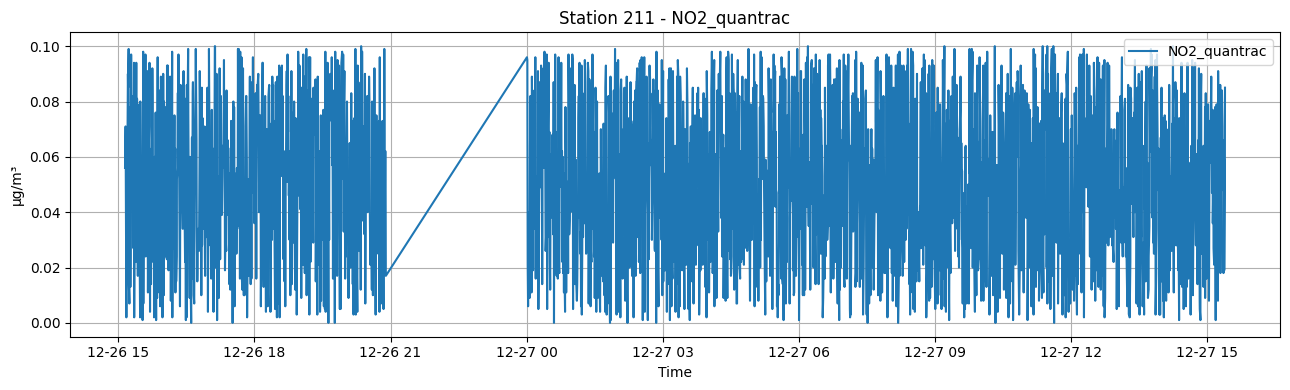

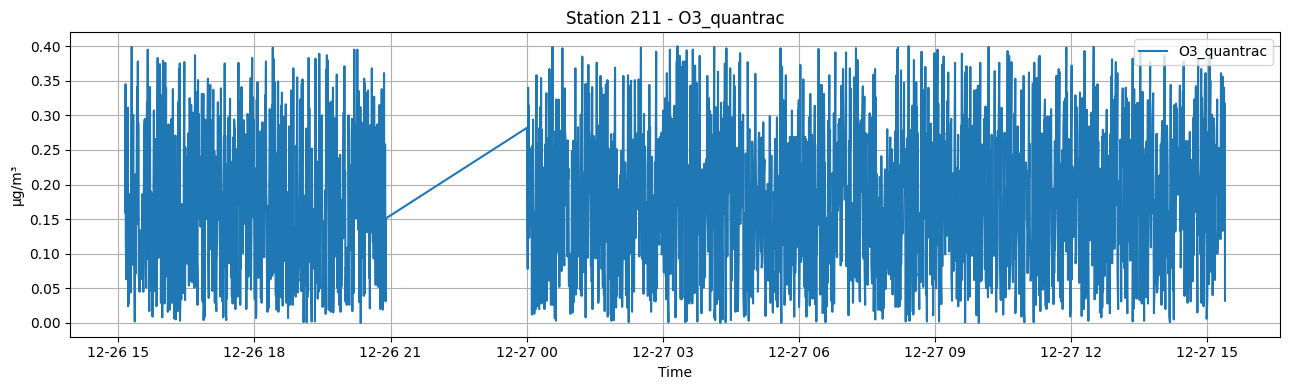

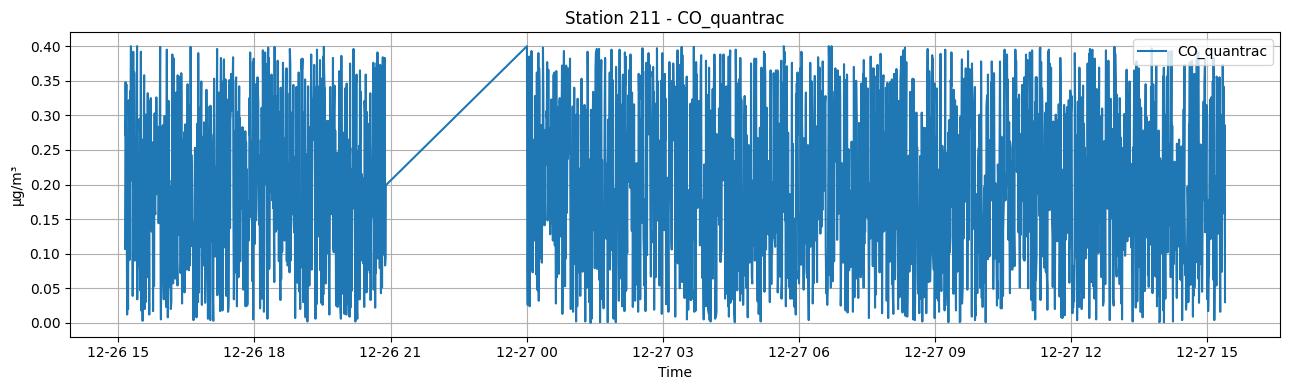

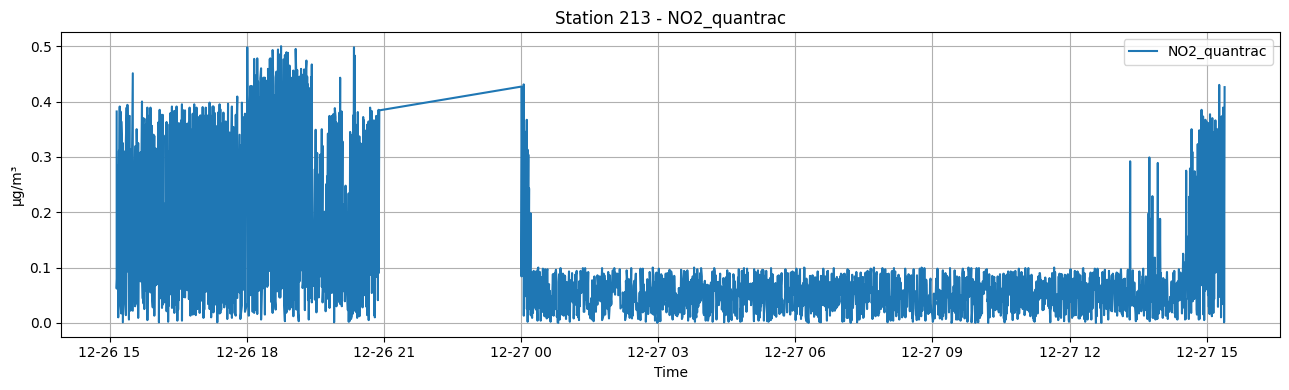

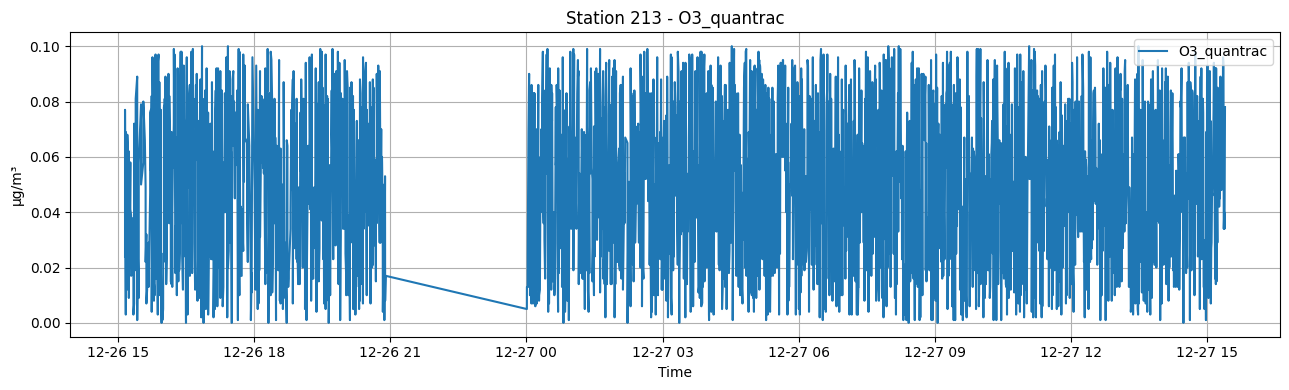

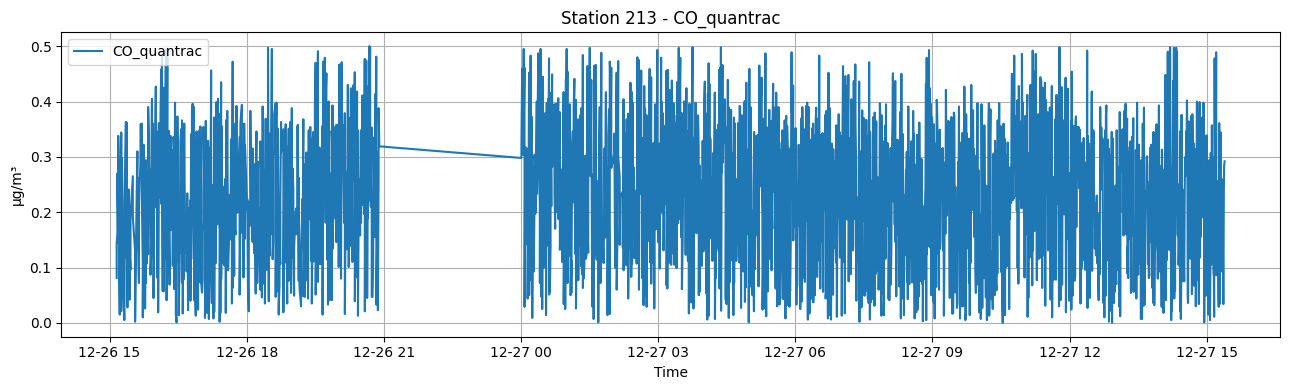

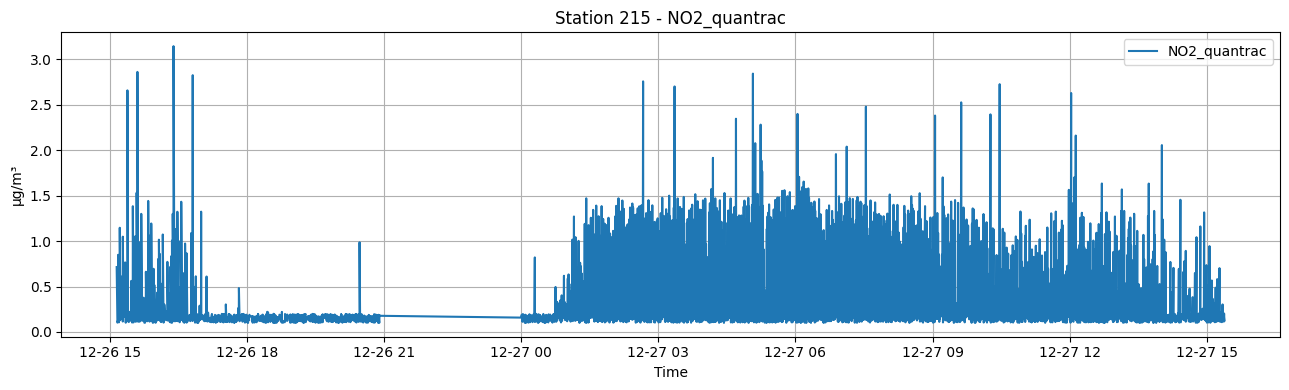

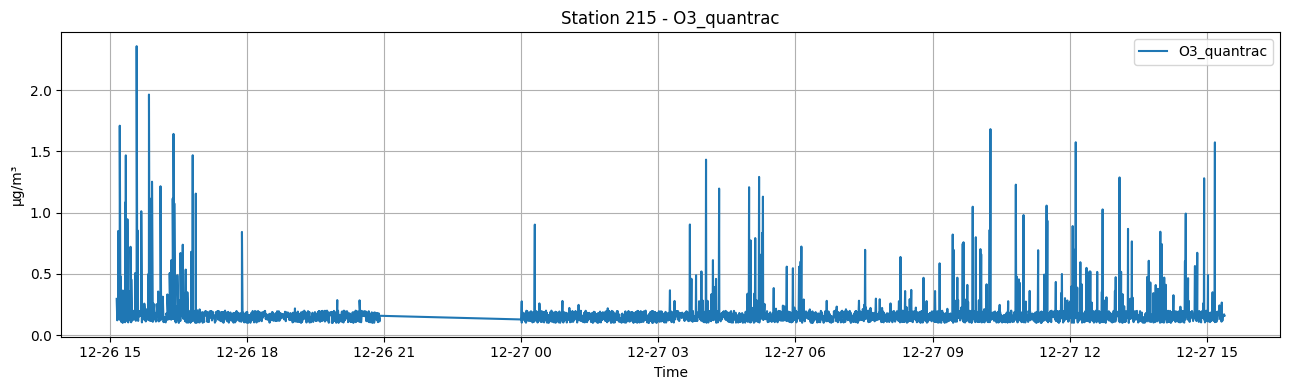

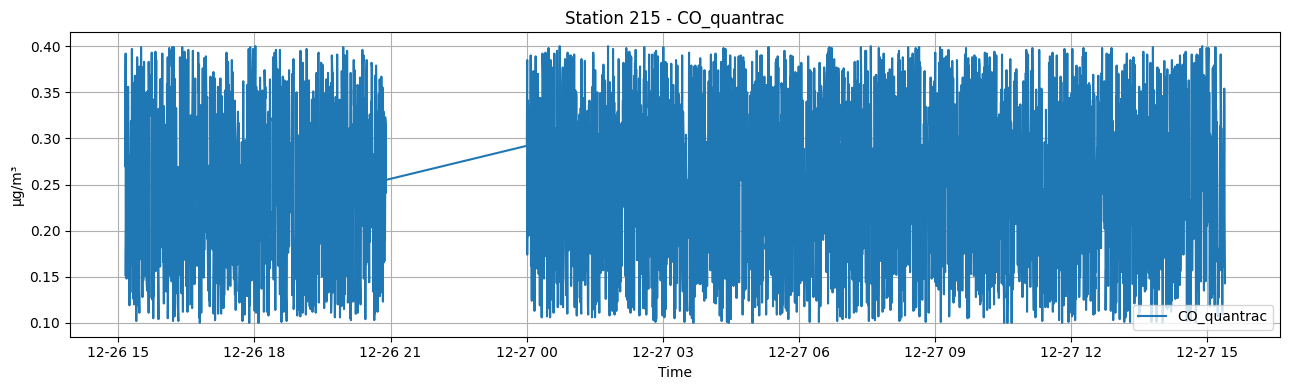

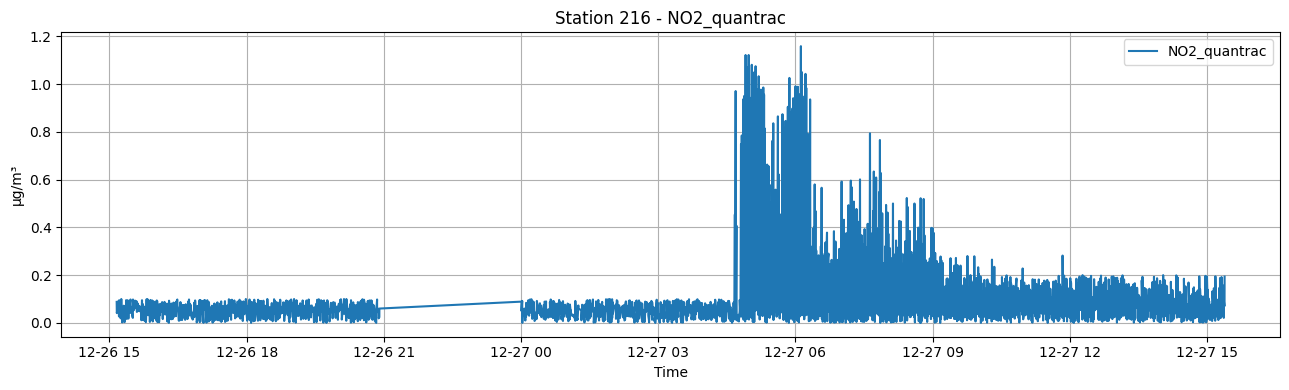

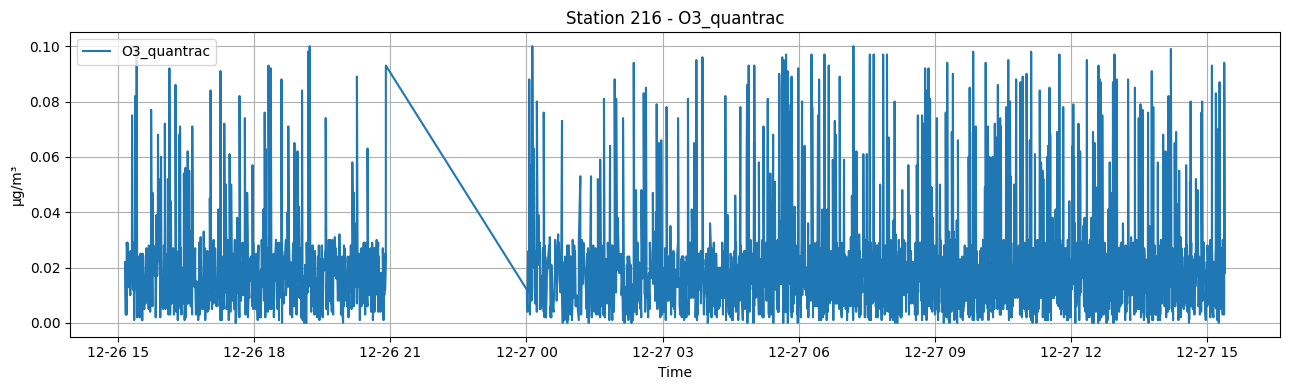

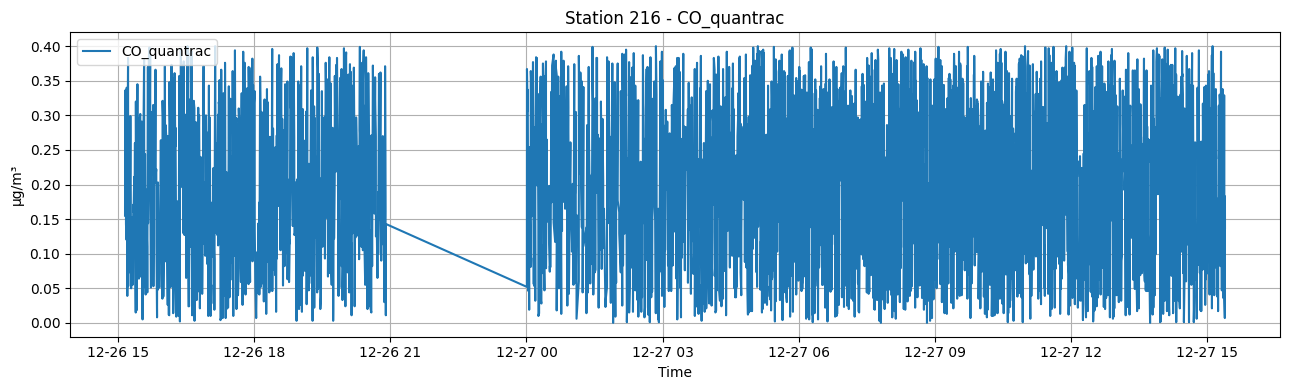

In [5]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [6]:
df_converted = copy.deepcopy(df_dropped)

'''
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted
'''

df_converted.loc[:, "NO2_quantrac"] = df_converted.loc[:, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "CO_quantrac"] = df_converted.loc[:, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[:, "O3_quantrac"] = df_converted.loc[:, "O3_quantrac"].apply(lambda x: x * 1960.0)

df_converted

NO2_quantrac  O3_quantrac  CO_quantrac  PM25_quantrac  \
0          105.4592       313.60     122.7076           24.0   
1          133.7072       676.20     399.0864           27.0   
2          101.6928       229.32     309.6360           22.0   
3            3.7664       123.48     395.6460           31.0   
4           41.4304       486.08     215.5984           36.0   
...             ...          ...          ...            ...   
11672       39.5472        11.76     377.2972           25.0   
11673      175.1376       184.24      42.4316           23.0   
11674      131.8240        35.28       8.0276           25.0   
11675      156.3056        39.20     209.8644           28.0   
11676      365.3408        43.12     157.1116           32.0   

       Temperature_quantrac  Humid_quantrac                date  station_id  
0                      25.7            86.0 2025-12-26 15:09:01         211  
1                      25.7            86.0 2025-12-26 15:09:46         211  
2                      25.7            86.0 2025-12-26 15:10:03         211  
3                      25.7            86.0 2025-12-26 15:10:48         211  
4                      25.7            86.0 2025-12-26 15:11:04         211  
...                     ...             ...                 ...         ...  
11672                  24.8            89.0 2025-12-27 15:22:03         216  
11673                  24.8            89.0 2025-12-27 15:22:09         216  
11674                  24.9            89.0 2025-12-27 15:22:55         216  
11675                  24.8            89.0 2025-12-27 15:23:04         216  
11676                  24.8            89.0 2025-12-27 15:23:09         216  

[11677 rows x 8 columns]

## Visualization after converting unit

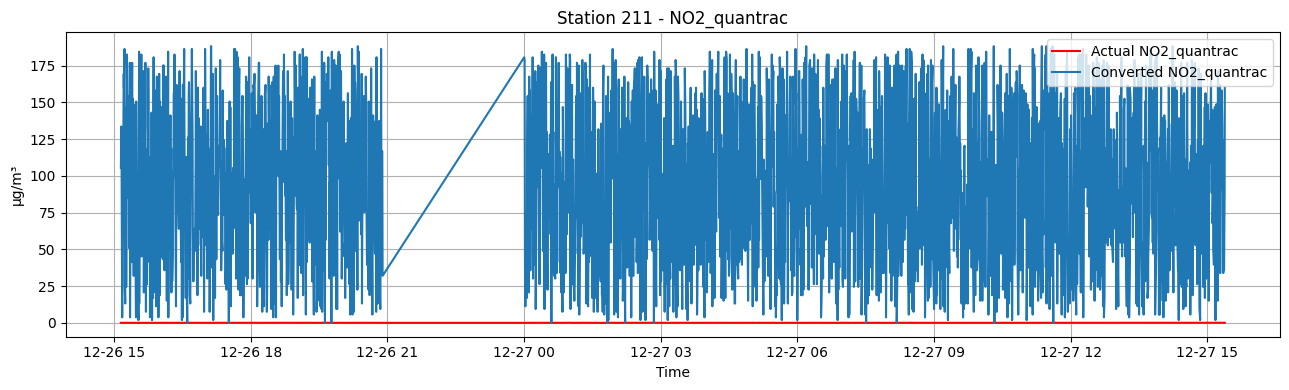

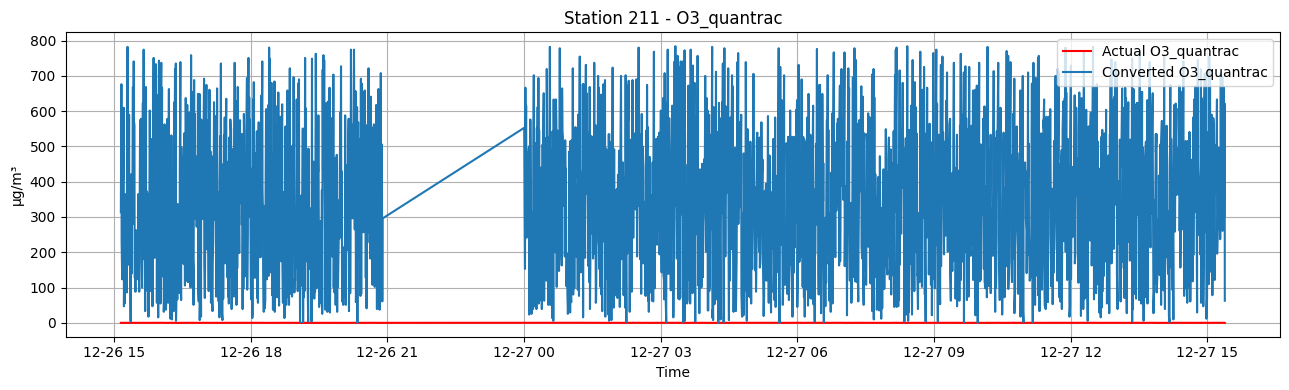

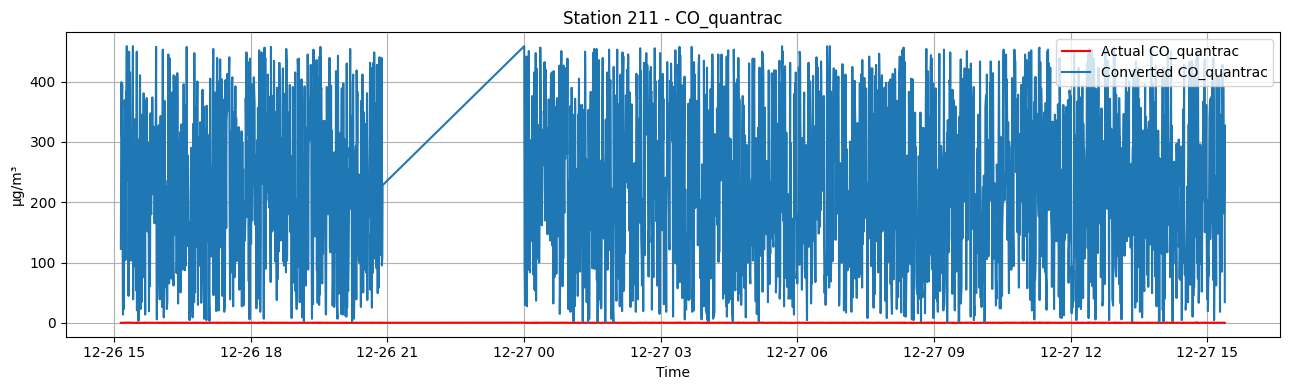

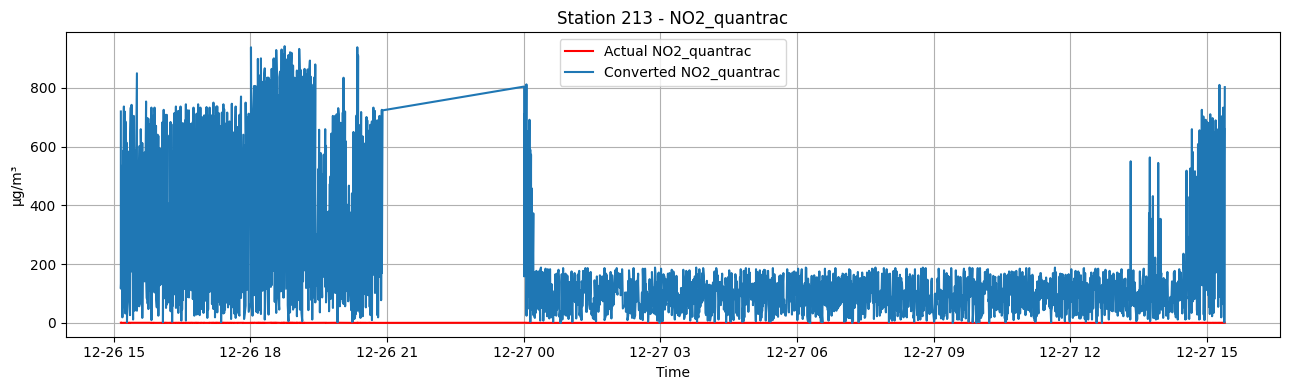

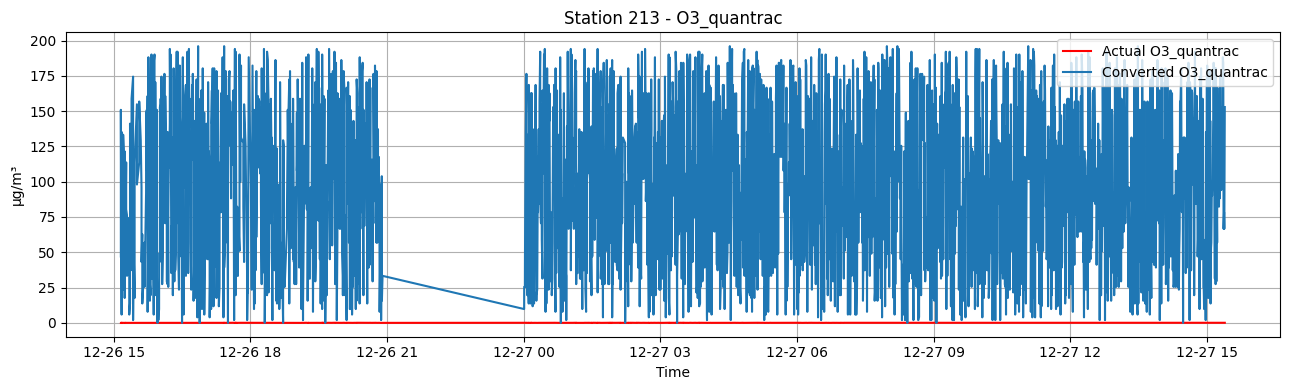

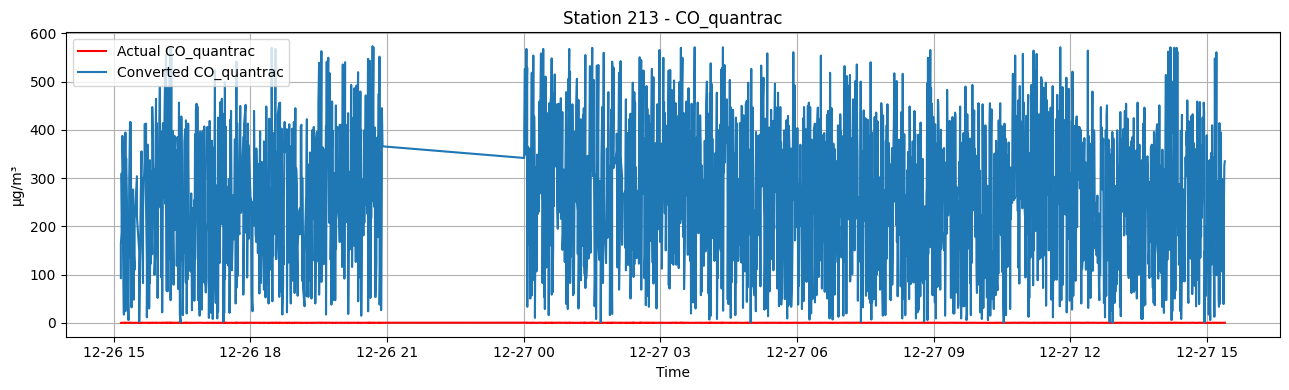

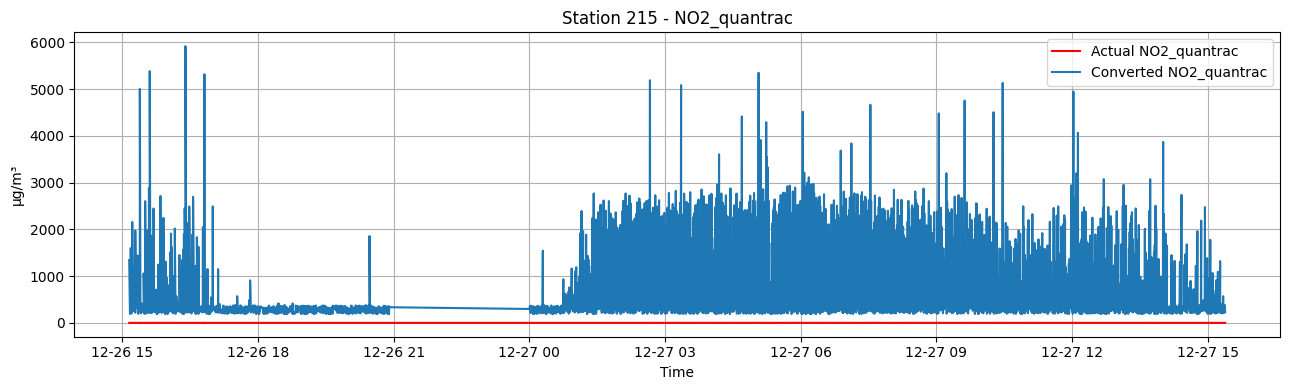

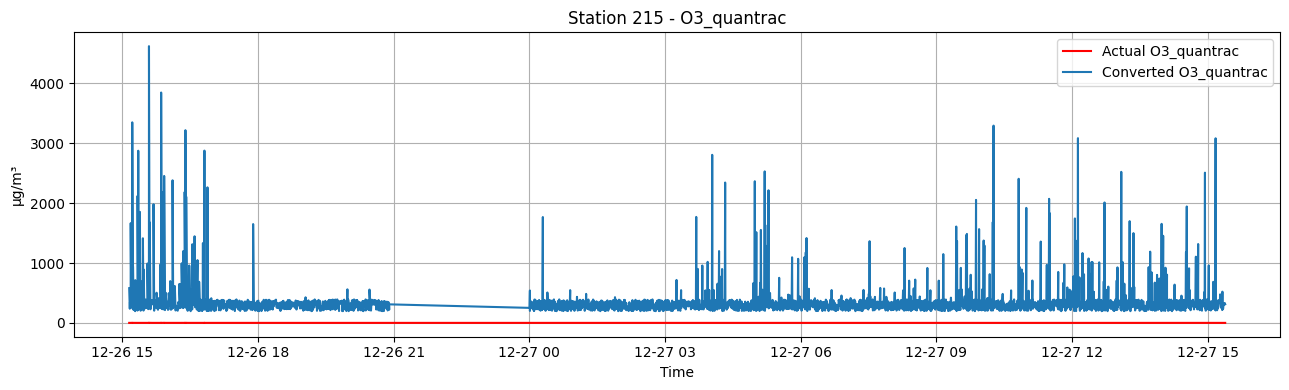

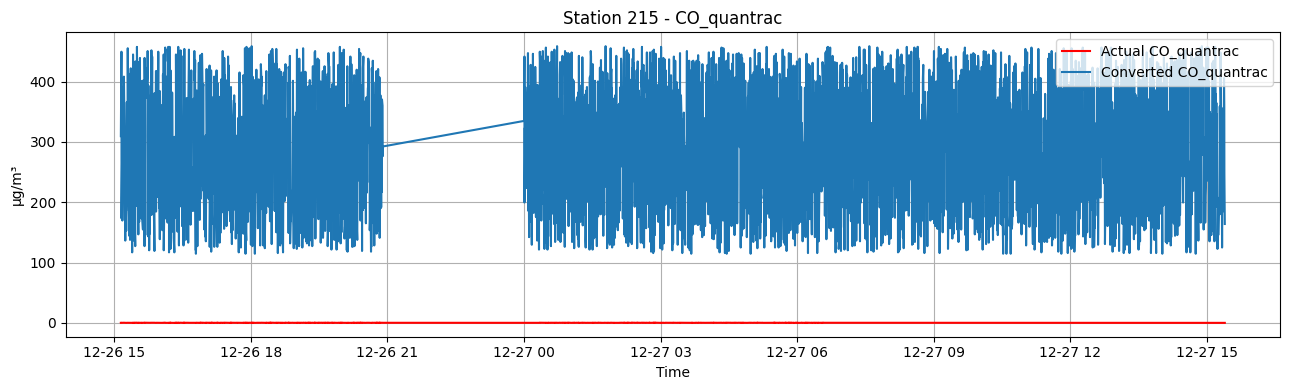

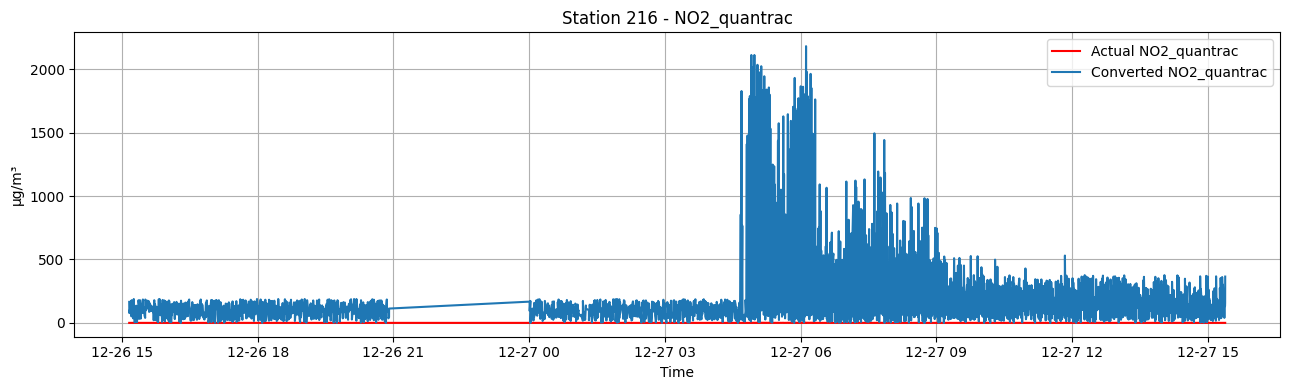

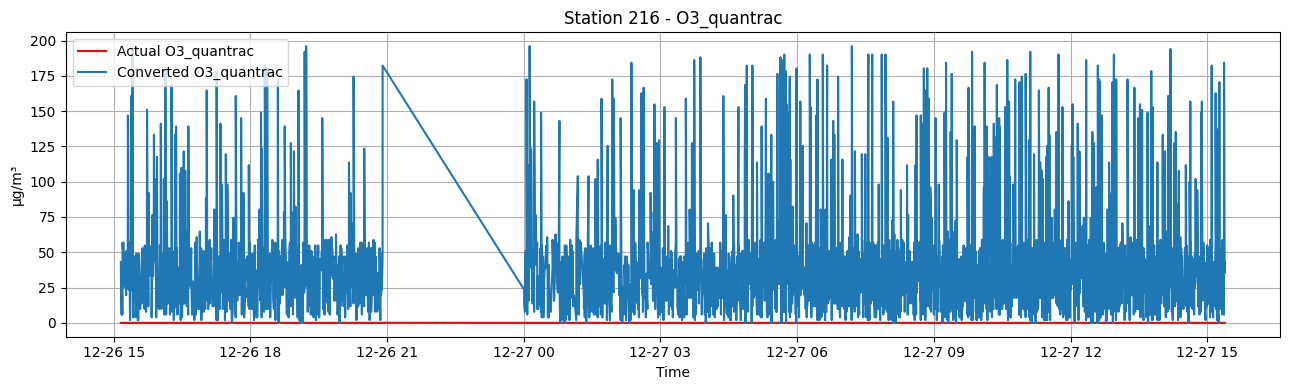

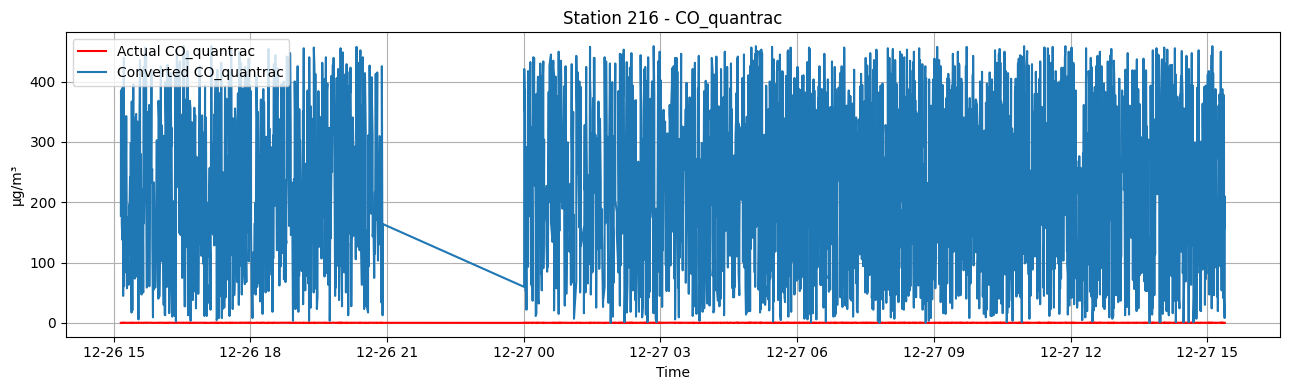

In [7]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [8]:
'''
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)
'''

'\ntest = copy.deepcopy(df_converted)\n\nlenbefore = len(test)\nprint(f"Before: {lenbefore} records")\n\n# 212 CO quantrac\ntest212 = test[test["station_id"] == 212]\ntest = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)\n\n# 213 CO quantrac\ntest213 = test[test["station_id"] == 213]\ntest = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)\n\n# 214 CO quantrac\ntest214 = test[test["station_id"] == 214]\ntest = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)\n\n# 215 NO2 quantrac\n# 215 CO quantrac\ntest215 = test[test["station_id"] == 215]\ntest = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)\ntest = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)\n\n# 216 CO quantrac\ntest216 = test[test["station_id"] == 216]\ntest = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)\n\nlenafter = len(test)\nprint(f"After: {lenafter} records")\nprint(f"Removed {lenbefore - lenafter} records")\n\ndf_converted = test.res

## Visualization after removing outliers

In [9]:
'''
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")
'''

'\nfor station in STATION_IDS:\n    df_station = df_converted[df_converted["station_id"] == station]\n    for target_col in df_station.columns:\n        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:\n            plot_1_data(df_station, target_col, f"Actual {target_col}",\n                        df_station["date"], f"Station {station} - {target_col}")\n                        #df_station.index, f"Station {station} - {target_col}")\n    print("\n" + "=" * 150 + "\n")\n'

# Prepare test data with 72 records

In [10]:
'''
df_test = df_converted.iloc[0:72]
df_test
'''
df_test = copy.deepcopy(df_converted)

In [11]:
'''
data = {}
for col in df_test.columns:
    new_col = col.lower().replace("_quantrac", "")
    data[new_col] = [str(item) for item in df_test[col].to_list()]

for k,v in data.items():
    print(f'"{k}": ', end='')
    if k == "date":
        formatted_items = [f'"{item}"' for item in v]
        print(f"[{', '.join(formatted_items)}],")
    else:
        formatted_items = [f'{item}' for item in v]
        print(f"[{', '.join(formatted_items)}],")
    print("\n")
'''

'\ndata = {}\nfor col in df_test.columns:\n    new_col = col.lower().replace("_quantrac", "")\n    data[new_col] = [str(item) for item in df_test[col].to_list()]\n\nfor k,v in data.items():\n    print(f\'"{k}": \', end=\'\')\n    if k == "date":\n        formatted_items = [f\'"{item}"\' for item in v]\n        print(f"[{\', \'.join(formatted_items)}],")\n    else:\n        formatted_items = [f\'{item}\' for item in v]\n        print(f"[{\', \'.join(formatted_items)}],")\n    print("\n")\n'

# LightGBM

### Adding time/lag features

In [12]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_test)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

print(df_lag_feats.columns)
display(df_lag_feats)

Index(['NO2_quantrac', 'O3_quantrac', 'CO_quantrac', 'PM25_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'date', 'station_id', 'hour',
       'dayofweek', 'month', 'NO2_quantrac_lag2', 'NO2_quantrac_lag3',
       'NO2_quantrac_lag6', 'NO2_quantrac_lag12', 'NO2_quantrac_lag24',
       'NO2_quantrac_lag48', 'NO2_quantrac_lag71', 'PM25_quantrac_lag2',
       'PM25_quantrac_lag3', 'PM25_quantrac_lag6', 'PM25_quantrac_lag12',
       'PM25_quantrac_lag24', 'PM25_quantrac_lag48', 'PM25_quantrac_lag71',
       'O3_quantrac_lag2', 'O3_quantrac_lag3', 'O3_quantrac_lag6',
       'O3_quantrac_lag12', 'O3_quantrac_lag24', 'O3_quantrac_lag48',
       'O3_quantrac_lag71', 'CO_quantrac_lag2', 'CO_quantrac_lag3',
       'CO_quantrac_lag6', 'CO_quantrac_lag12', 'CO_quantrac_lag24',
       'CO_quantrac_lag48', 'CO_quantrac_lag71', 'Temperature_quantrac_lag2',
       'Temperature_quantrac_lag3', 'Temperature_quantrac_lag6',
       'Temperature_quantrac_lag12', 'Temperature_quantrac_lag24',
 

NO2_quantrac  O3_quantrac  CO_quantrac  PM25_quantrac  \
0          105.4592       313.60     122.7076           24.0   
1          133.7072       676.20     399.0864           27.0   
2          101.6928       229.32     309.6360           22.0   
3            3.7664       123.48     395.6460           31.0   
4           41.4304       486.08     215.5984           36.0   
...             ...          ...          ...            ...   
11672       39.5472        11.76     377.2972           25.0   
11673      175.1376       184.24      42.4316           23.0   
11674      131.8240        35.28       8.0276           25.0   
11675      156.3056        39.20     209.8644           28.0   
11676      365.3408        43.12     157.1116           32.0   

       Temperature_quantrac  Humid_quantrac                date  station_id  \
0                      25.7            86.0 2025-12-26 15:09:01         211   
1                      25.7            86.0 2025-12-26 15:09:46         211   
2                      25.7            86.0 2025-12-26 15:10:03         211   
3                      25.7            86.0 2025-12-26 15:10:48         211   
4                      25.7            86.0 2025-12-26 15:11:04         211   
...                     ...             ...                 ...         ...   
11672                  24.8            89.0 2025-12-27 15:22:03         216   
11673                  24.8            89.0 2025-12-27 15:22:09         216   
11674                  24.9            89.0 2025-12-27 15:22:55         216   
11675                  24.8            89.0 2025-12-27 15:23:04         216   
11676                  24.8            89.0 2025-12-27 15:23:09         216   

       hour  dayofweek  ...  Temperature_quantrac_lag24  \
0        15          4  ...                         NaN   
1        15          4  ...                         NaN   
2        15          4  ...                         NaN   
3        15          4  ...                         NaN   
4        15          4  ...                         NaN   
...     ...        ...  ...                         ...   
11672    15          5  ...                        24.8   
11673    15          5  ...                        24.8   
11674    15          5  ...                        24.9   
11675    15          5  ...                        24.8   
11676    15          5  ...                        24.8   

       Temperature_quantrac_lag48  Temperature_quantrac_lag71  \
0                             NaN                         NaN   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   
...                           ...                         ...   
11672                        24.8                        24.8   
11673                        24.8                        24.9   
11674                        24.9                        24.8   
11675                        24.8                        24.8   
11676                        24.8                        24.9   

       Humid_quantrac_lag2  Humid_quantrac_lag3  Humid_quantrac_lag6  \
0                      NaN                  NaN                  NaN   
1                      NaN                  NaN                  NaN   
2                     86.0                  NaN                  NaN   
3                     86.0                 86.0                  NaN   
4                     86.0                 86.0                  NaN   
...                    ...                  ...                  ...   
11672                 89.0                 89.0                 89.0   
11673                 89.0                 89.0                 89.0   
11674                 89.0                 89.0                 89.0   
11675                 89.0                 89.0                 89.0   
11676  

## NO2_quantrac

{211: [7.782829, -4.09747, -4.5961213, 3.8078797], 212: [3.5855365, -3.9908829, -2.4162335, 1.0250082], 213: [2.9658248, -3.1664917, -2.539614, 2.5171337], 214: [1.5897979, -2.4742687, -4.4660373, 2.1730874], 215: [2.984351, -3.522223, -1.998513, 2.4715588], 216: [5.107183, -5.4918914, -6.1699085, 6.0908666]}
Horizon:  1
y_pred: =  [117.72579263 133.47908402 131.42735066 ... 125.71638838 127.43254633
 170.40138581]
y_pred_new: =  0         98.8808963155
1        120.4107420081
2        147.6328753309
3        109.3116808404
4         89.2592404049
              ...      
11384    200.0954903600
11385    204.0187587961
11386    115.5877941925
11387    117.3874731642
11388    161.9410929026
Name: NO2_quantrac_roll2_mean, Length: 11389, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 459.35, 'mae': 205.29, 'mape': 321.52, 'mnbe': -270.44, 'r': 0.58, 'n_samples': 11389}


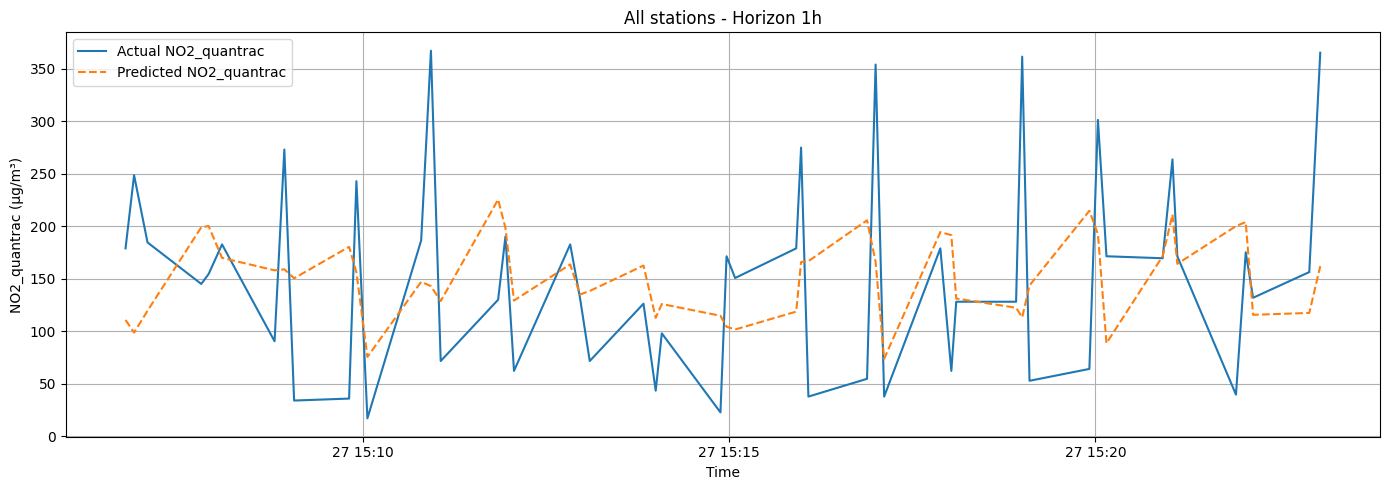


================================================== METRICS FOR EACH STATION ==================================================



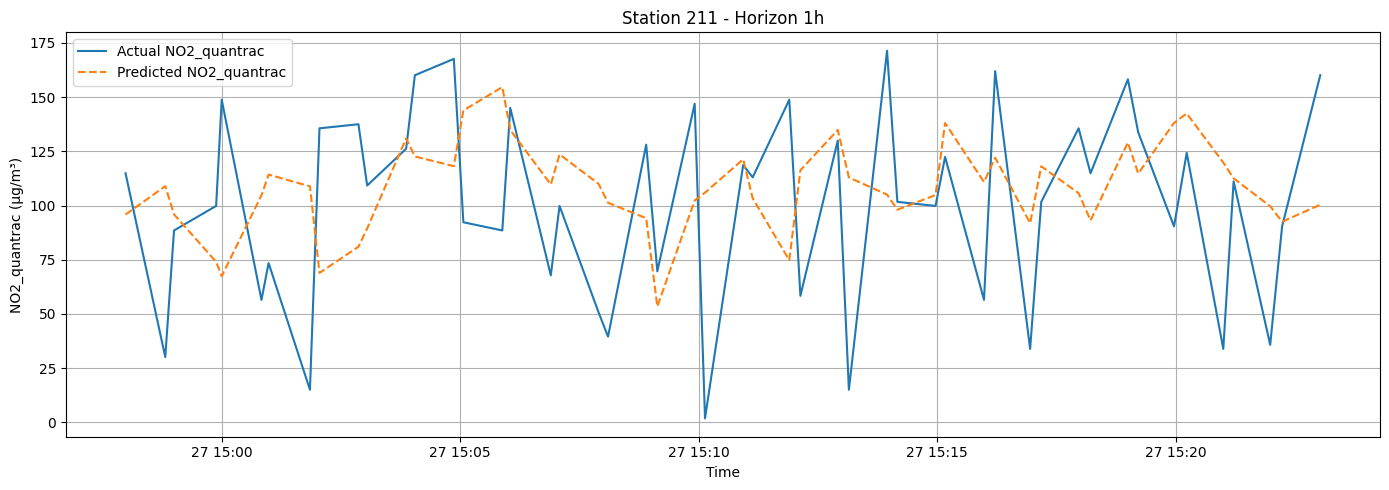

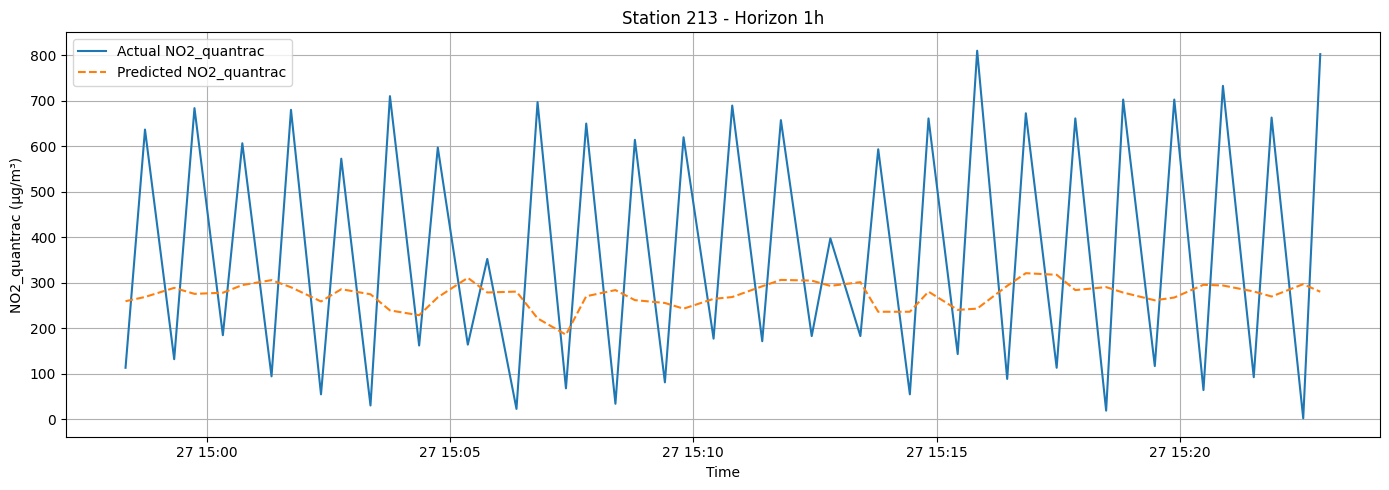

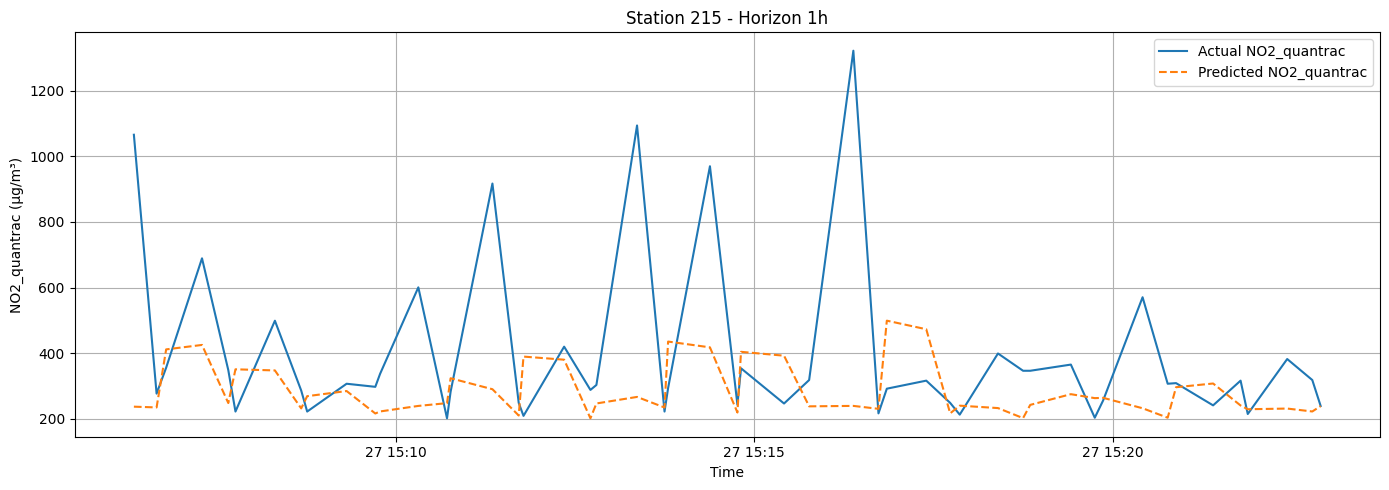

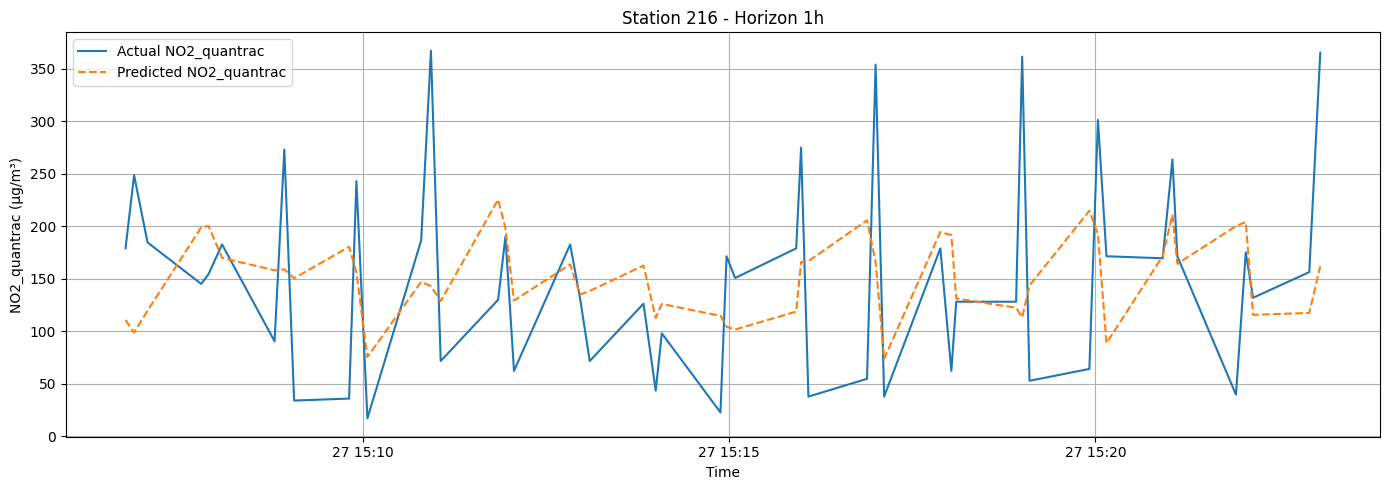

Horizon:  24
y_pred: =  [105.10814041  97.73420867 104.53317233 ...  99.2715679   99.24461274
 105.03756216]
y_pred_new: =  0         92.5720702036
1        102.5383043357
2        134.1857861664
3         96.5426670861
4         74.3026510853
              ...      
11292    102.7870916409
11293    100.9137382491
11294     92.0077839519
11295     84.9323063688
11296     82.6499810792
Name: NO2_quantrac_roll2_mean, Length: 11297, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 554.02, 'mae': 255.49, 'mape': 306.45, 'mnbe': -252.27, 'r': 0.13, 'n_samples': 11297}


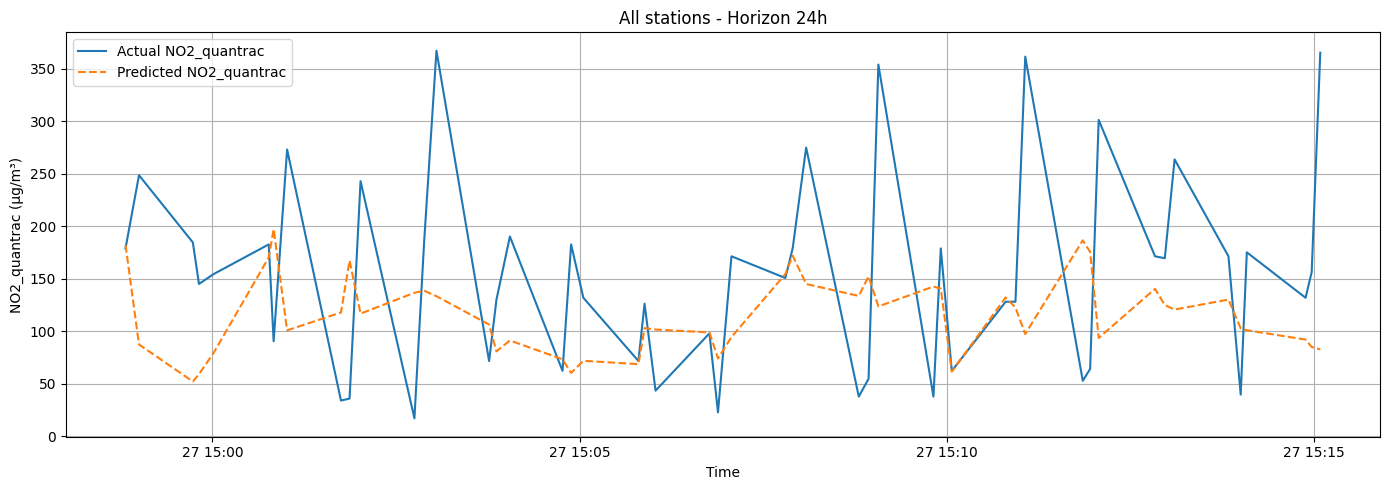


================================================== METRICS FOR EACH STATION ==================================================



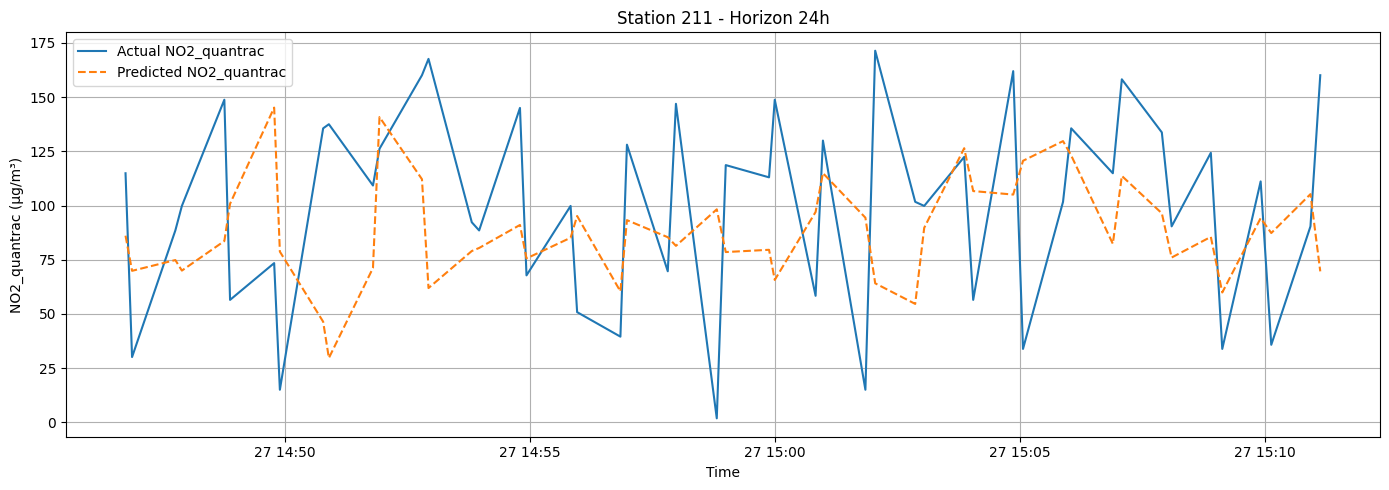

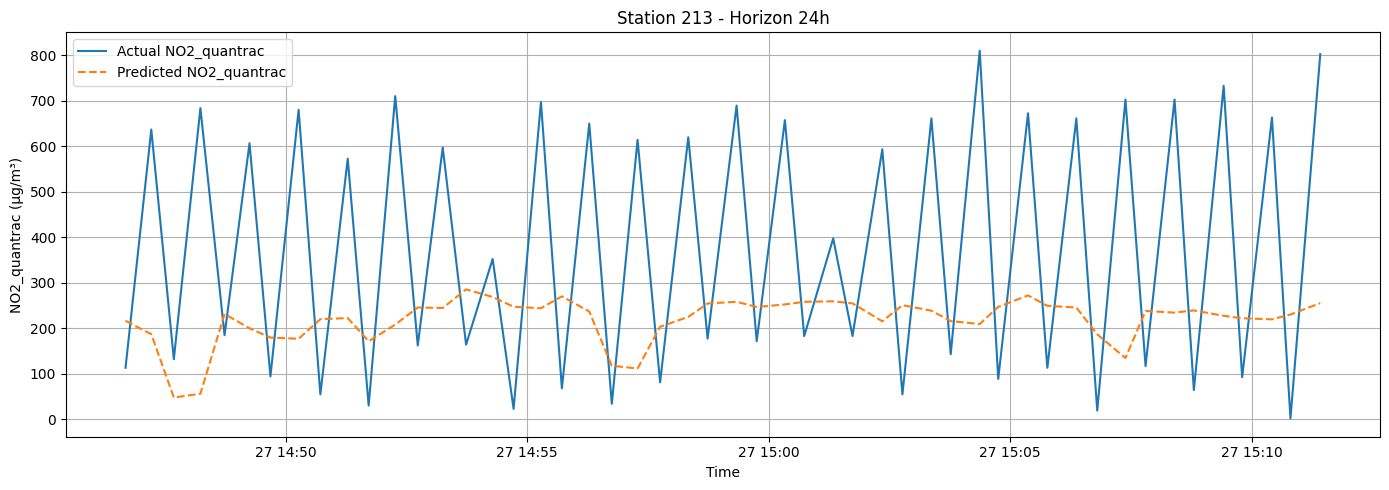

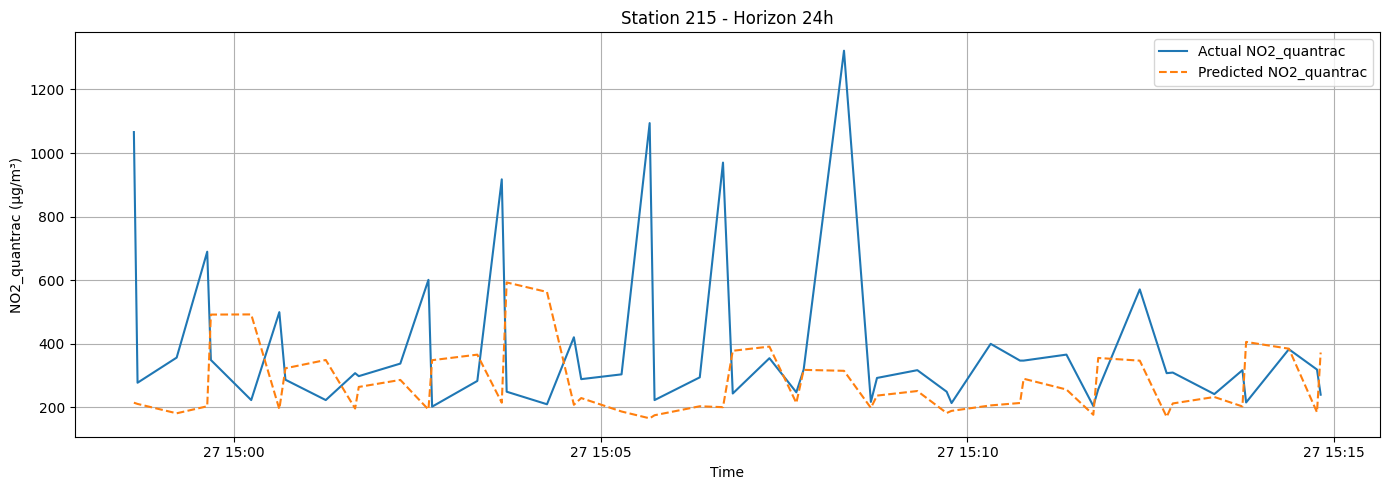

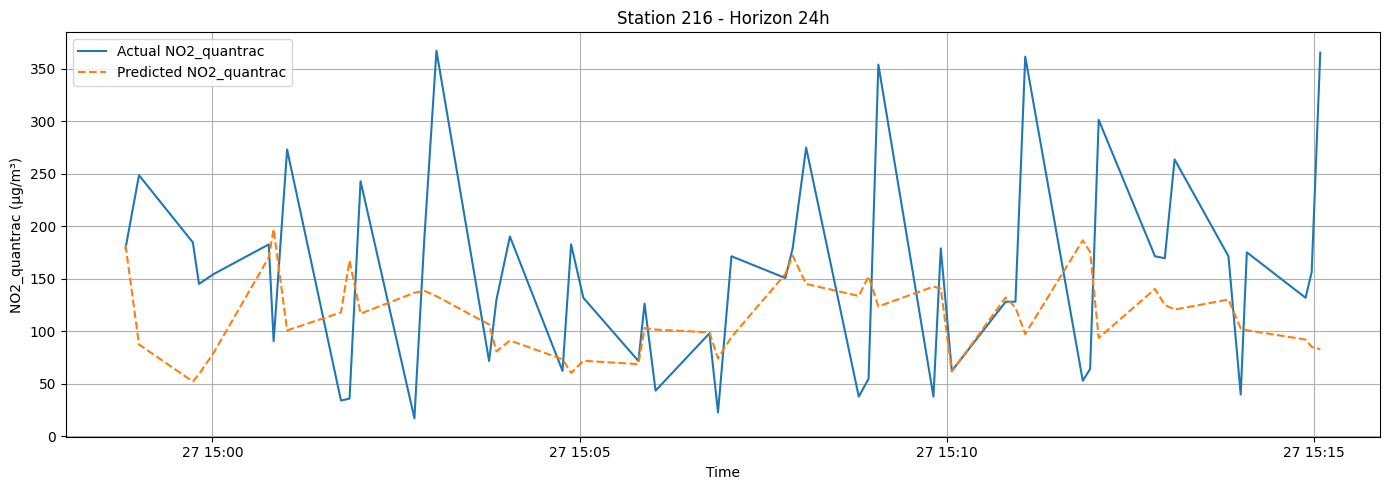

Horizon:  48
y_pred: =  [ 75.22841698  88.23426616  98.36798543 ...  98.35750216 115.9591099
 110.70493188]
y_pred_new: =  0         77.6322084905
1         97.7883330795
2        131.1031927168
3         99.9247333344
4         64.5051311496
              ...      
11196    102.7625277568
11197    100.9139588484
11198     97.2003510809
11199     88.5815549500
11200    103.8448659424
Name: NO2_quantrac_roll2_mean, Length: 11201, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 554.63, 'mae': 253.9, 'mape': 293.93, 'mnbe': -237.85, 'r': 0.13, 'n_samples': 11201}


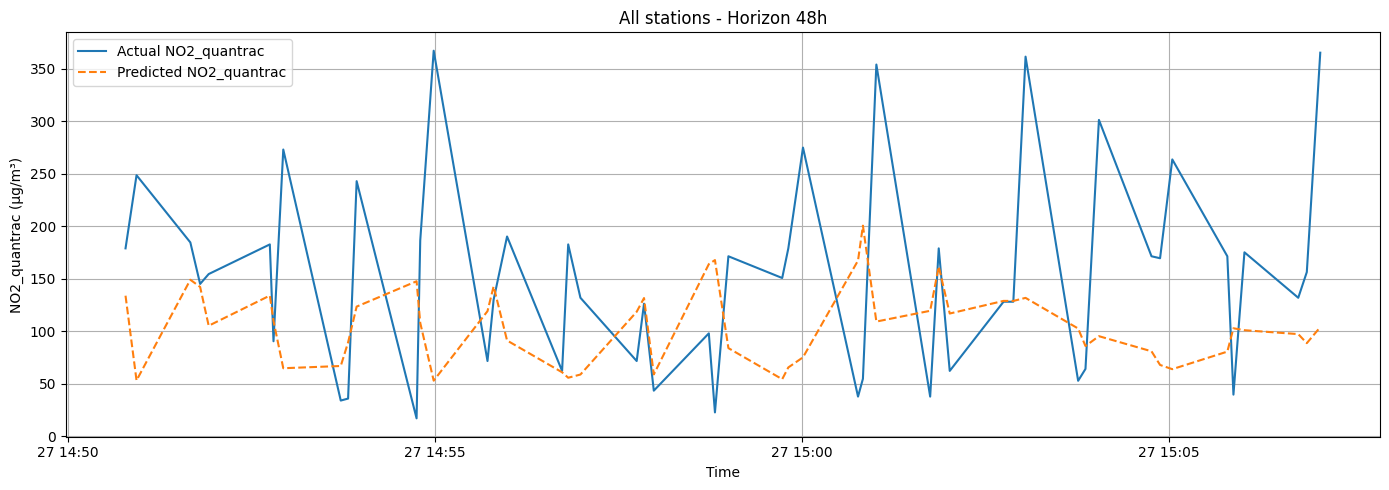


================================================== METRICS FOR EACH STATION ==================================================



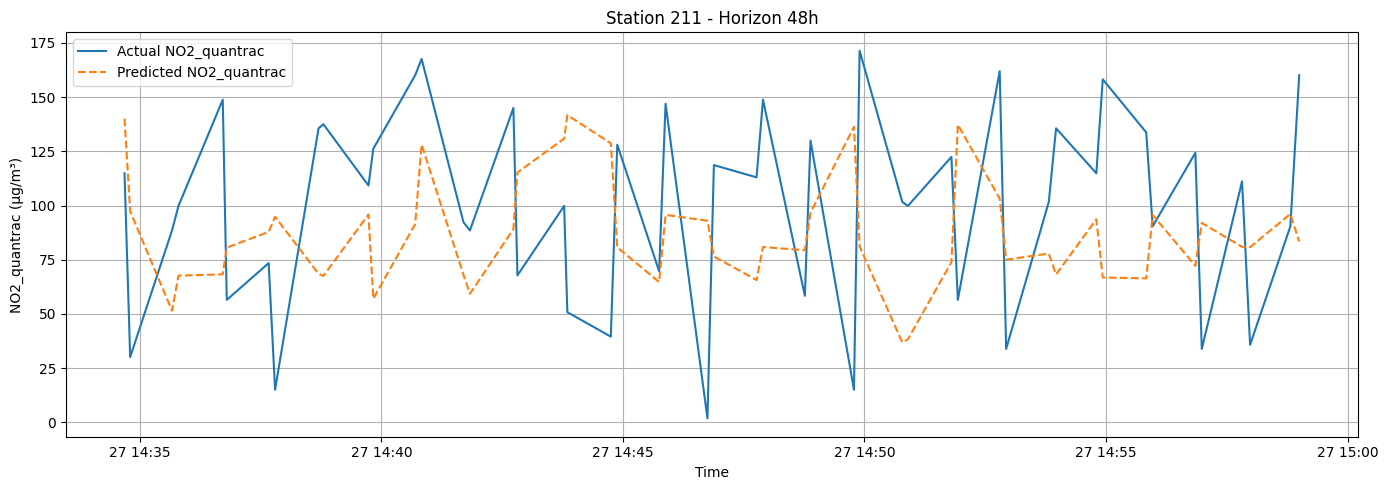

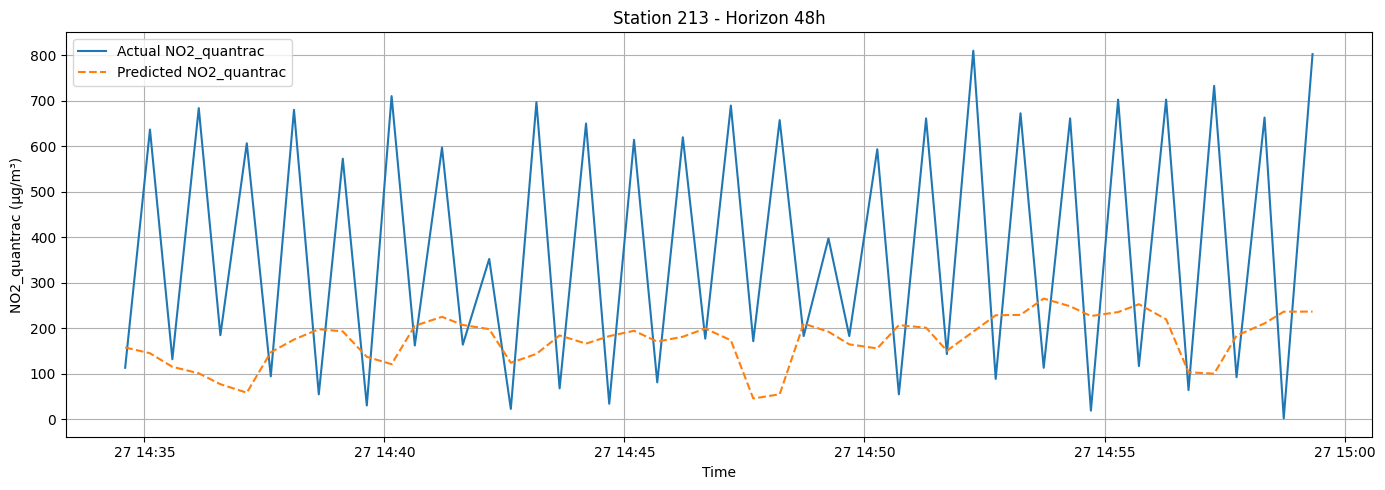

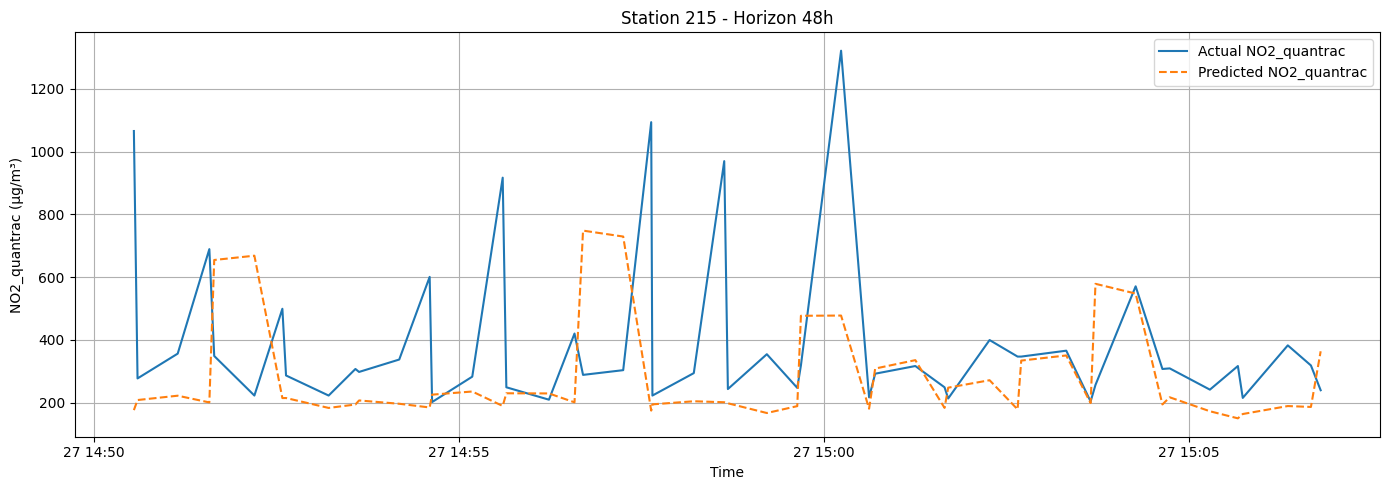

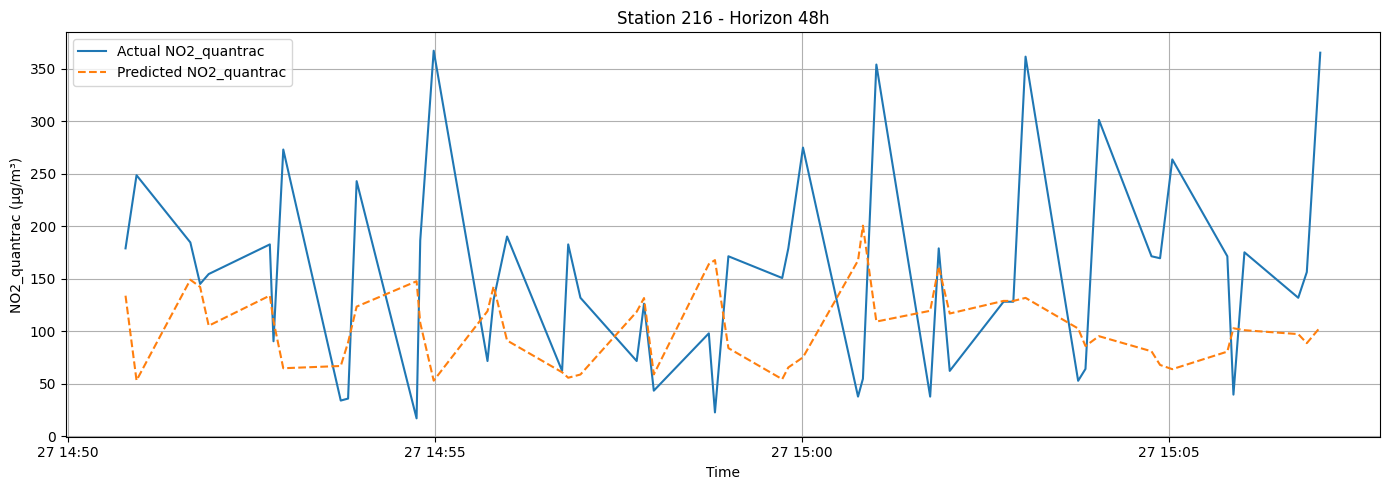

Horizon:  72
y_pred: =  [ 94.64635222 100.98236384 112.17764685 ...  94.77877019  46.27351543
  62.39364309]
y_pred_new: =  0         87.3411761115
1        104.1623819211
2        138.0080234268
3         97.1912574683
4         80.7795957086
              ...      
11100    126.6260453655
11101     55.4416193993
11102    143.9033850953
11103    140.8367577174
11104     74.0396215459
Name: NO2_quantrac_roll2_mean, Length: 11105, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 551.52, 'mae': 251.15, 'mape': 289.71, 'mnbe': -233.21, 'r': 0.16, 'n_samples': 11105}


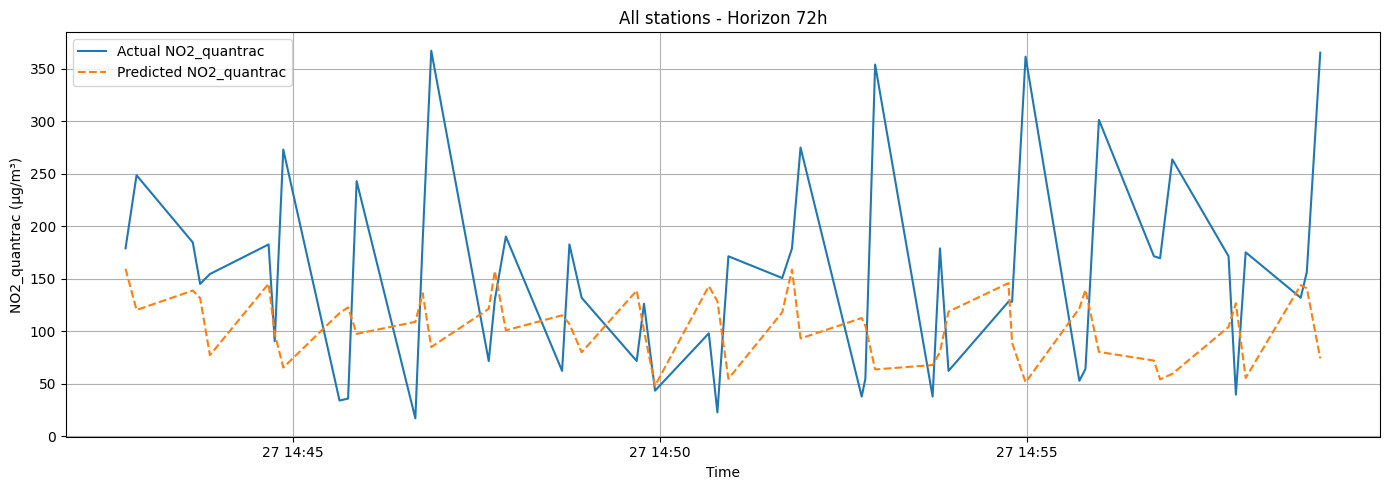


================================================== METRICS FOR EACH STATION ==================================================



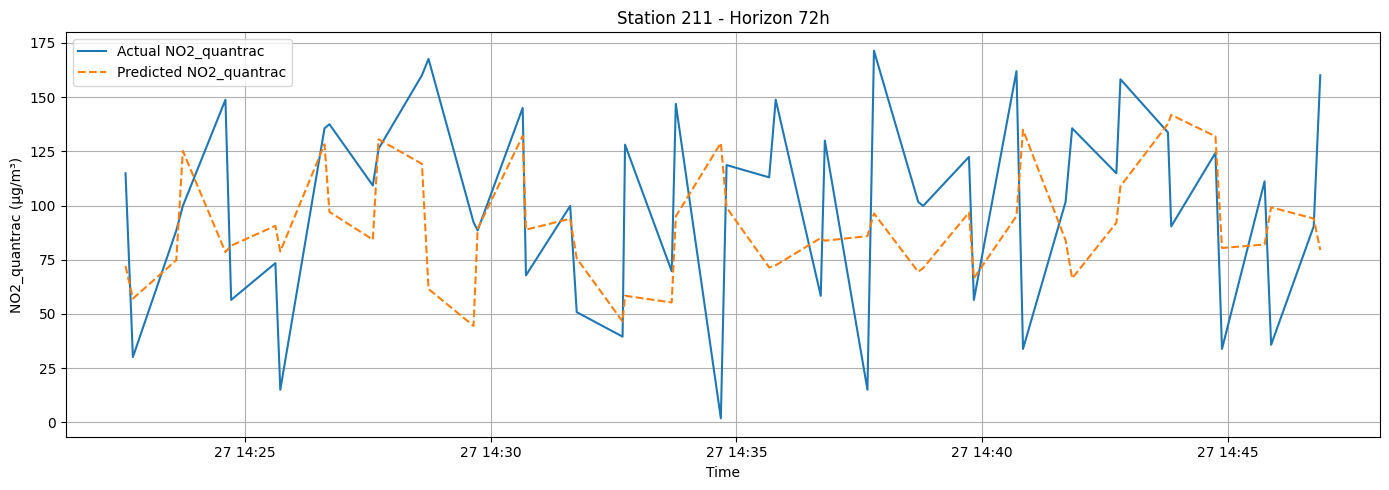

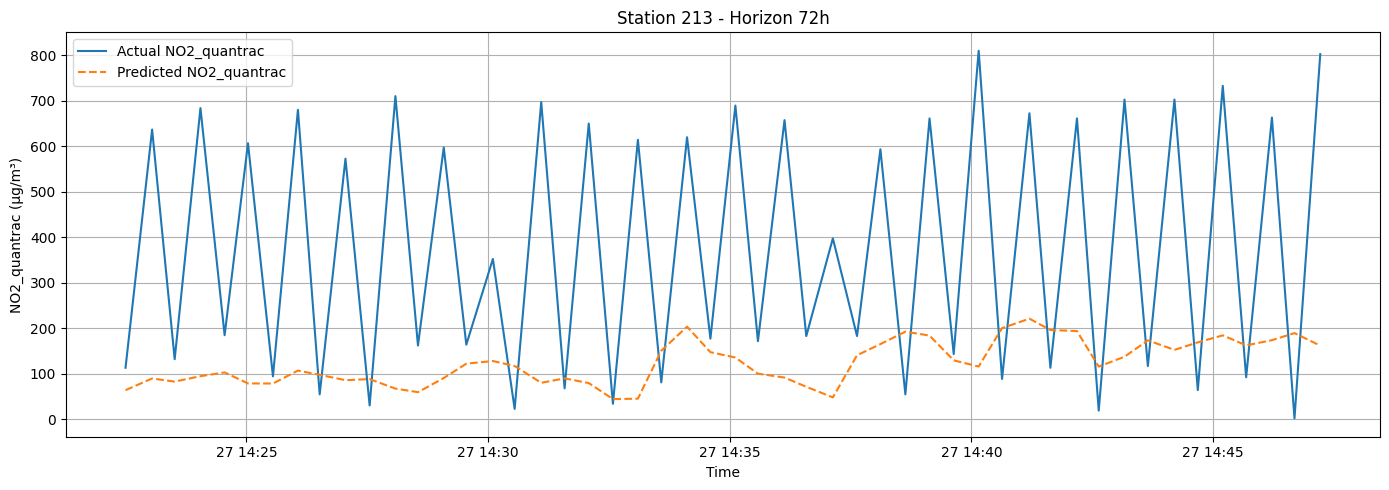

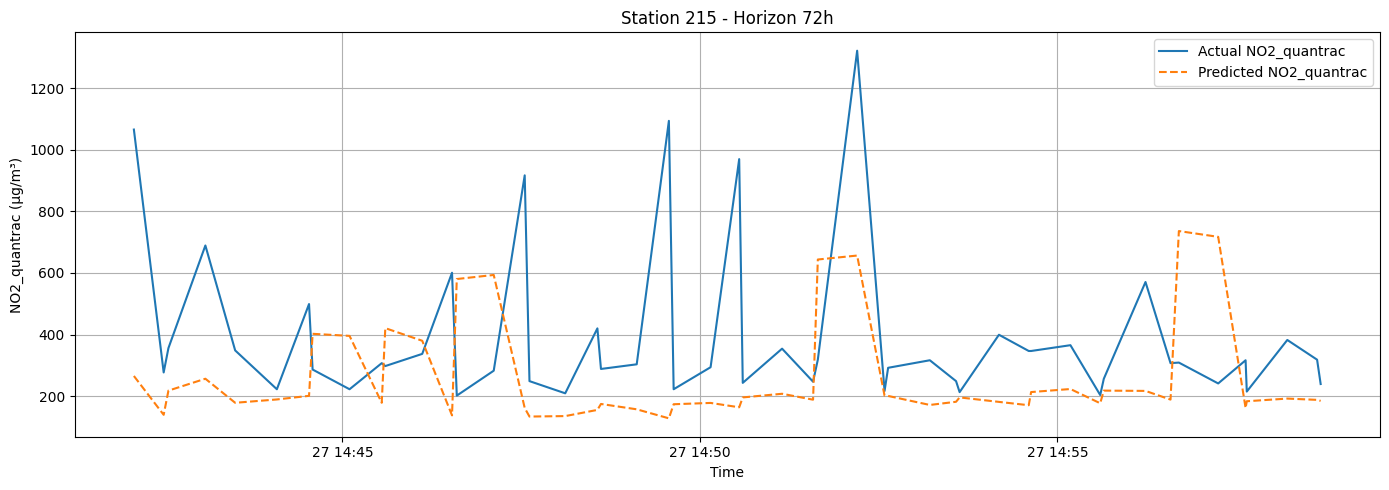

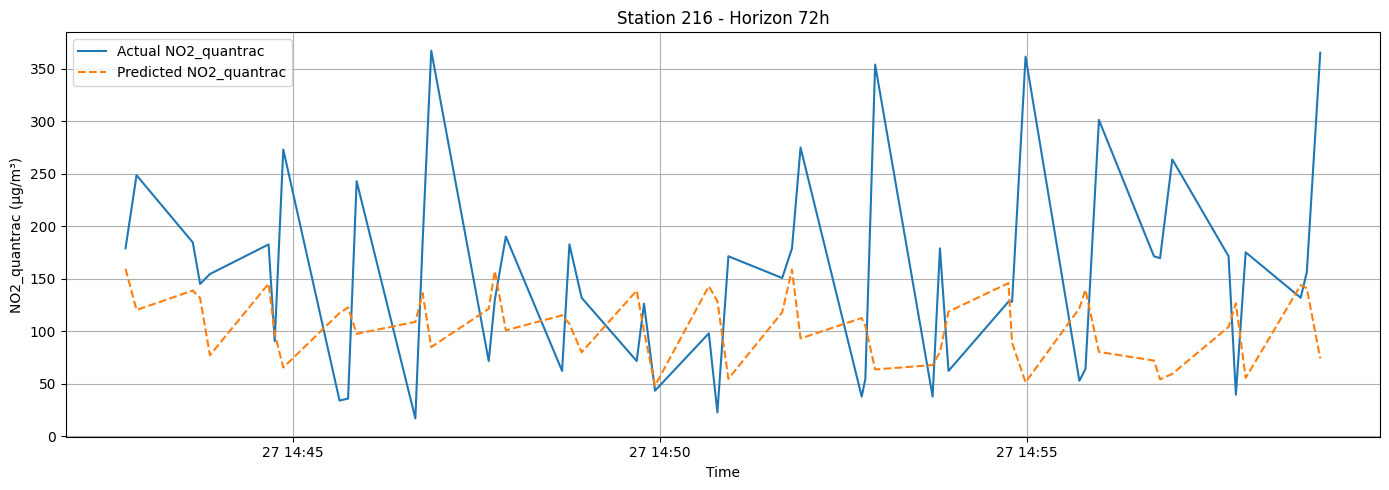

station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211          1   61.09   50.99  188.83 -158.05 -0.01       2430   
0      211         24   60.79   51.06  183.64 -150.96 -0.00       2407   
0      211         72   58.02   48.85  186.15 -157.49  0.05       2359   
0      211         48   60.79   51.17  184.78 -151.69 -0.01       2383   
1      213         48  188.64  116.91  187.90 -138.04  0.48       2300   
1      213         72  190.26  115.80  179.77 -128.04  0.45       2276   
1      213         24  185.02  117.63  201.15 -155.52  0.50       2324   
1      213          1  176.09  116.02  223.09 -183.04  0.57       2347   
2      215         72  925.73  555.07   81.75  -18.10 -0.22       3533   
2      215         48  931.03  559.45   82.80  -21.78 -0.26       3557   
2      215          1  770.57  432.45   59.37   -8.82  0.41       3604   
2      215         24  930.03  561.41   84.39  -28.43 -0.29       3581   
3      216         24  307.17  160.67  276.42 -232.55 -0.05       2985   
3      216          1  245.50  127.44  249.53 -212.81  0.54       3008   
3      216         48  302.89  156.43  267.93 -223.69  0.01       2961   
3      216         72  297.45  152.93  263.49 -219.10  0.08       2937   

   avg_mnbe  
0     -8.87  
0     -4.71  
0     -6.67  
0     -4.36  
1     28.03  
1     30.37  
1     22.02  
1     15.19  
2     40.01  
2     39.24  
2     32.98  
2     35.33  
3     11.15  
3      2.31  
3     11.65  
3     13.97

In [49]:
# Add rolling features for target_col
target_col = "NO2_quantrac"
df_no2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as no2_emb_file:
    no2_station_to_embedding = pickle.load(no2_emb_file)
print(no2_station_to_embedding)
df_no2, _ = attach_station_embedding(df_no2, no2_station_to_embedding, station_col="station_id")

# Dropna
df_no2 = df_no2.dropna()

all_hours_metrics = []
for horizon_h in HORIZONS:
    print("Horizon: ", horizon_h)
    # Build supervised
    X, y = build_supervised_for_horizon(df_no2, horizon_h, target_col)
    meta_cols = ["station_id", "date"]
    meta = X.loc[:, meta_cols]
    X = X.drop(columns=meta_cols)
    y = y.drop(columns=meta_cols)
    model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    y_pred = model.predict(X, num_iteration=getattr(test_model, "best_iteration", None))

    '''
    # Shift
    shift = 0
    if shift != 0:
        y_pred = y_pred[shift:]
        y = y.iloc[:-shift, :]
        X = X.iloc[:-shift, :]
        meta = meta.iloc[:-shift, :]
    '''

    # Plus rolling mean
    print("y_pred: = ", y_pred)
    a, b, rollmean = 0.5, 0.5, 2
    y_pred_new = a * y_pred + b * X[f"{target_col}_roll{rollmean}_mean"]
    print("y_pred_new: = ", y_pred_new)

    # Metrics overall
    print(f"\n{'=' * 50} OVERALL METRICS {'=' * 50}\n")
    metrics_overall = compute_metrics(y, y_pred_new)
    print(metrics_overall)
    plot_prediction(y, y_pred_new, meta, target_col, title=f"All stations - Horizon {horizon_h}h", n_points=50)

    # Metrics for each station
    print(f"\n{'=' * 50} METRICS FOR EACH STATION {'=' * 50}\n")
    df_true_test = meta.copy()
    df_true_test["y_true"] = y.values
    df_true_test["y_pred"] = y_pred_new
    rows = []
    for sid, grp in df_true_test.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        # Calculate avg mnbe
        avg_mnbe = mnbe_avg(grp["y_true"], grp["y_pred"], grp["date"])
        m["avg_mnbe"] = round(avg_mnbe, 2)
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
        plot_prediction(grp["y_true"], grp["y_pred"], grp[["date"]], target_col, title=f"Station {sid} - Horizon {horizon_h}h", n_points=50)
    metrics_by_station = pd.DataFrame(rows)
    all_hours_metrics.append(metrics_by_station)

all_hours_metrics = pd.concat(all_hours_metrics, axis=0)
all_hours_metrics = all_hours_metrics.sort_values(by=["station"], axis=0)
display(all_hours_metrics)

## O3_quantrac

{211: [6.3102427, -2.830071, -3.242811, -5.710138], 212: [5.6497054, -6.1378117, -4.827483, -6.0162816], 213: [4.3873553, -4.6534095, -4.2588835, -2.8678885], 214: [3.096077, -4.051208, -6.2767863, -3.596666], 215: [5.033126, -5.672511, -4.3594937, -5.4653296], 216: [3.4363449, -4.0281177, -4.587953, -2.7763786]}
Horizon:  1
y_pred: =  [193.56917392 192.24612975  79.08480039 ...  26.84650868  94.50538107
  85.28895596]
y_pred_new: =  0        210.9545869610
1        210.2930648736
2         66.4924001971
3        177.4612325307
4        237.4138981261
              ...      
11384     26.1855519157
11385     18.4206475418
11386     17.8332543416
11387     96.2526905359
11388     97.5244779801
Name: O3_quantrac_roll2_mean, Length: 11389, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 192.15, 'mae': 98.92, 'mape': 377.4, 'mnbe': -316.94, 'r': 0.56, 'n_samples': 11389}


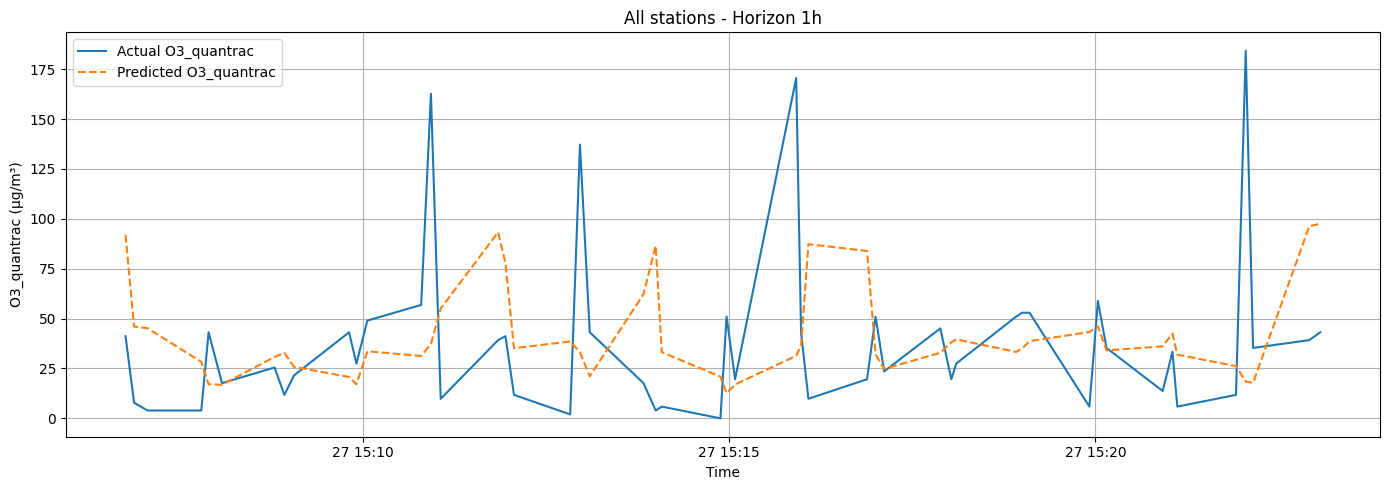


================================================== METRICS FOR EACH STATION ==================================================



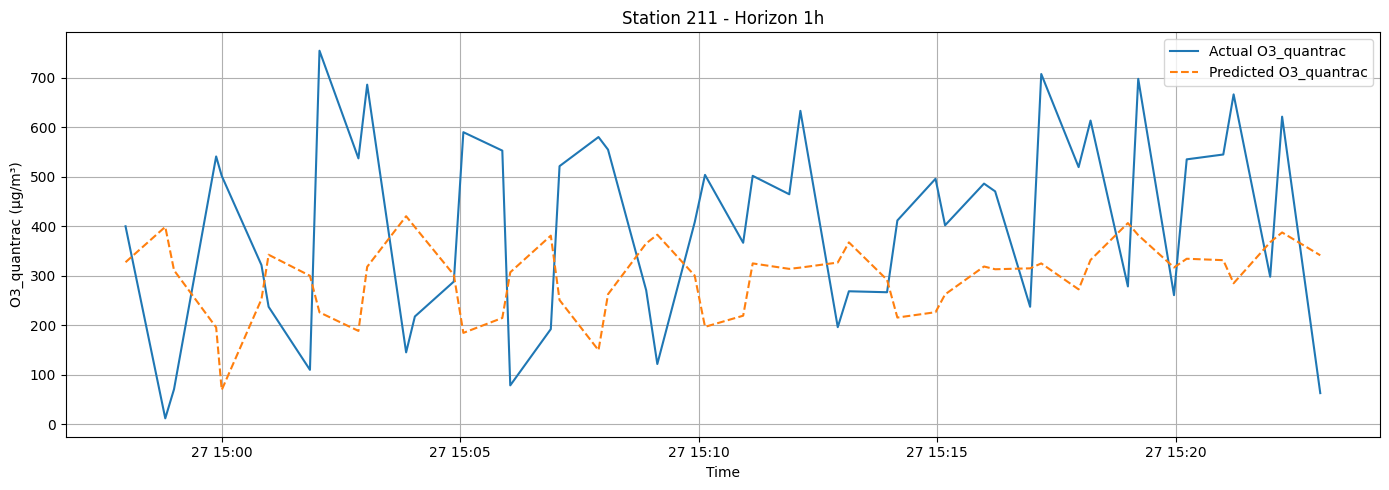

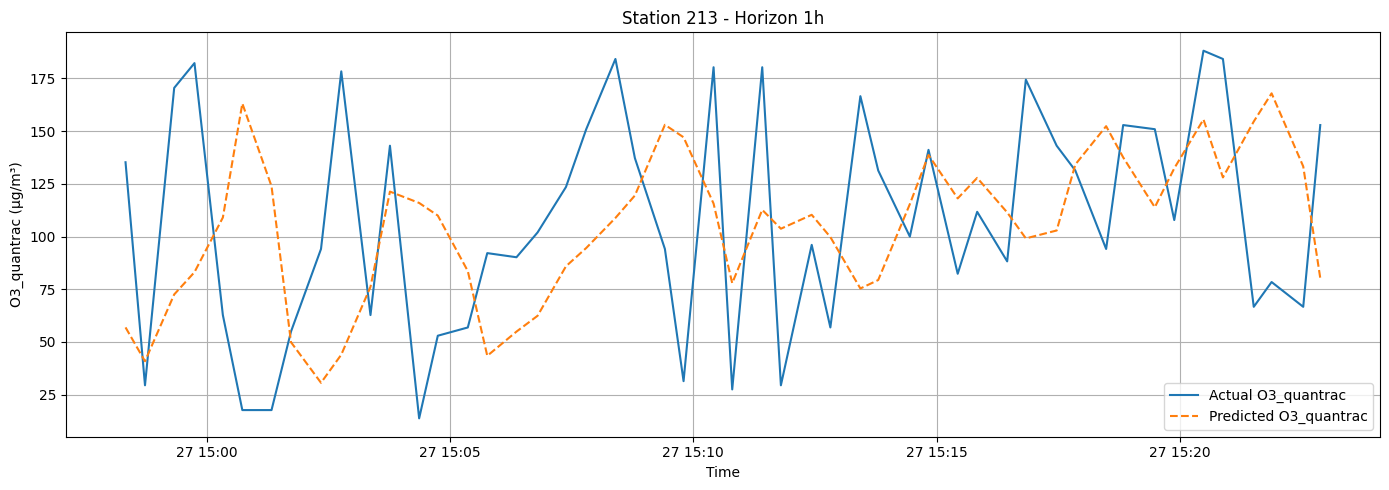

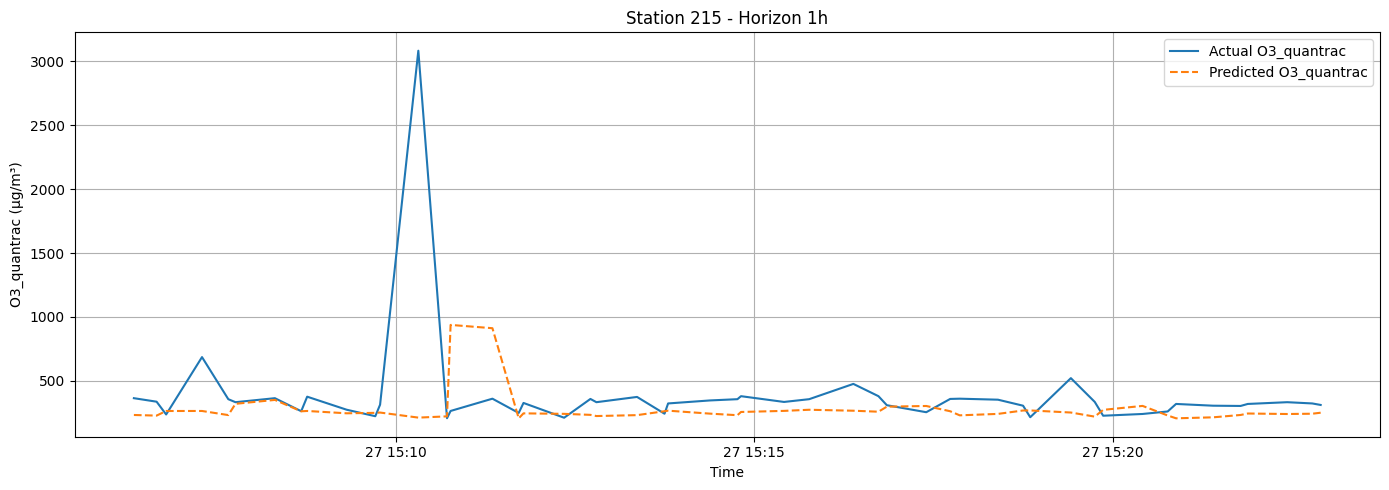

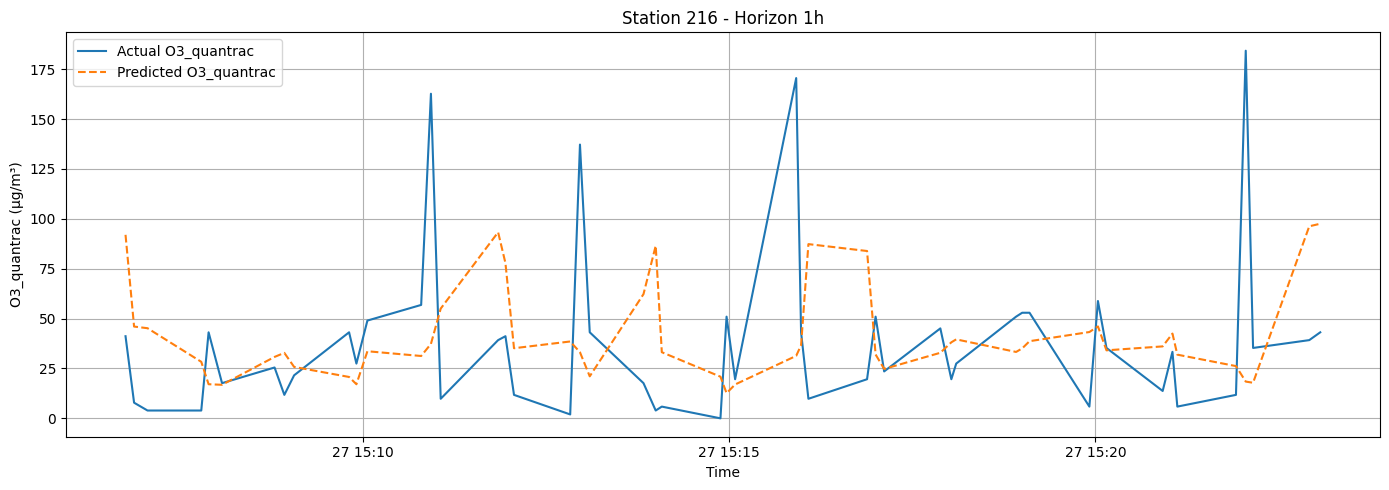

station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211          1  239.63  197.44  227.54 -172.09 -0.02       2430   
1      213          1   64.76   54.12  207.12 -170.69  0.02       2347   
2      215          1  271.63  120.14   27.88   14.62  0.15       3604   
3      216          1   41.58   28.85  181.48 -146.39 -0.02       3008   

   avg_mnbe  
0     25.03  
1     -1.15  
2     25.14  
3     -2.11

Horizon:  24
y_pred: =  [171.62199337 177.75405855  97.60153702 ...  39.15487831  29.23802152
  33.5301085 ]
y_pred_new: =  0        199.9809966863
1        203.0470292729
2         75.7507685115
3        180.4505651592
4        234.5272966195
              ...      
11292     86.8546359514
11293     33.8178196058
11294     24.9674391559
11295     17.0690107614
11296     18.2350542522
Name: O3_quantrac_roll2_mean, Length: 11297, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 195.07, 'mae': 101.08, 'mape': 367.55, 'mnbe': -307.45, 'r': 0.51, 'n_samples': 11297}


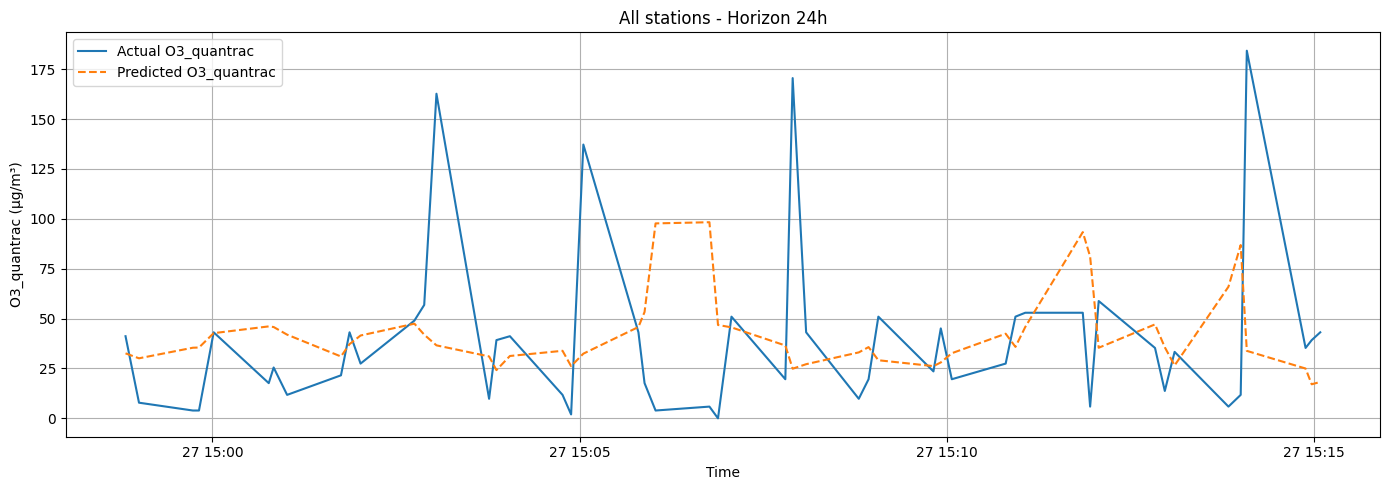


================================================== METRICS FOR EACH STATION ==================================================



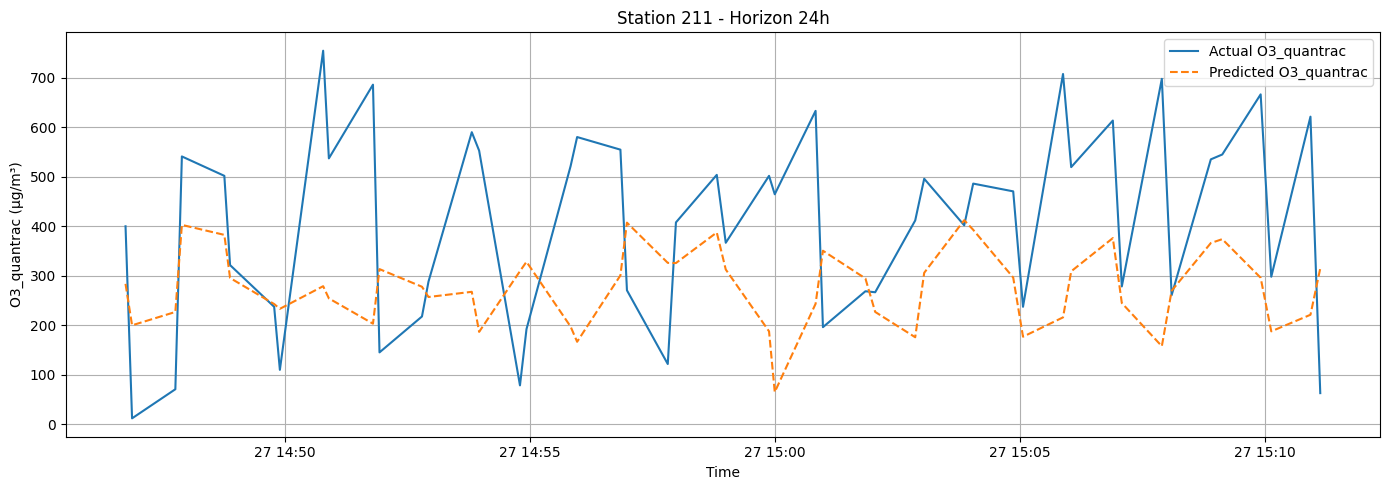

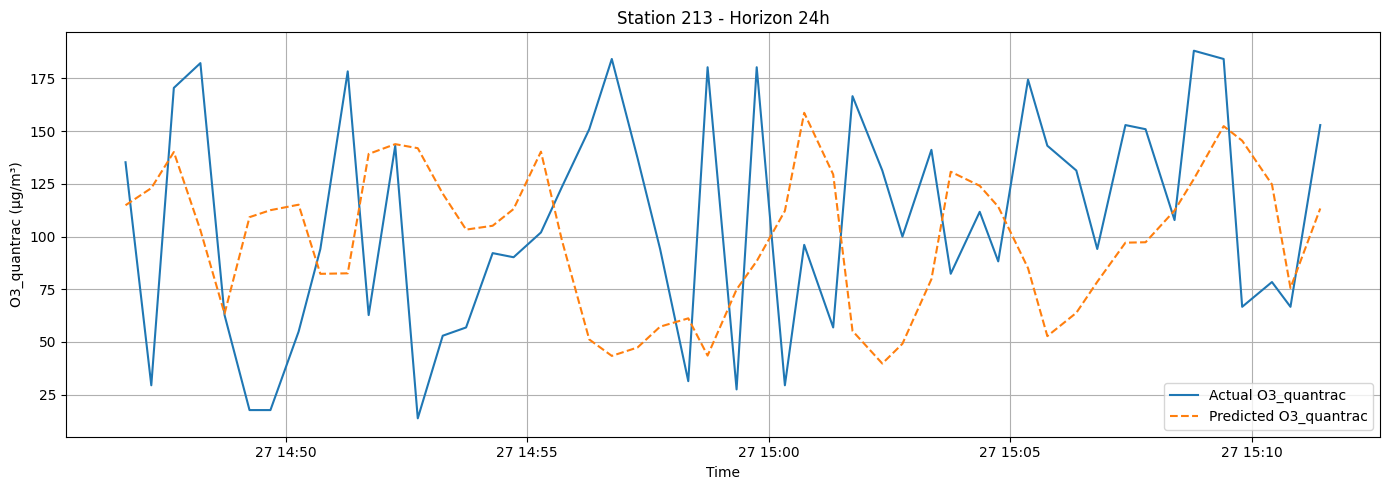

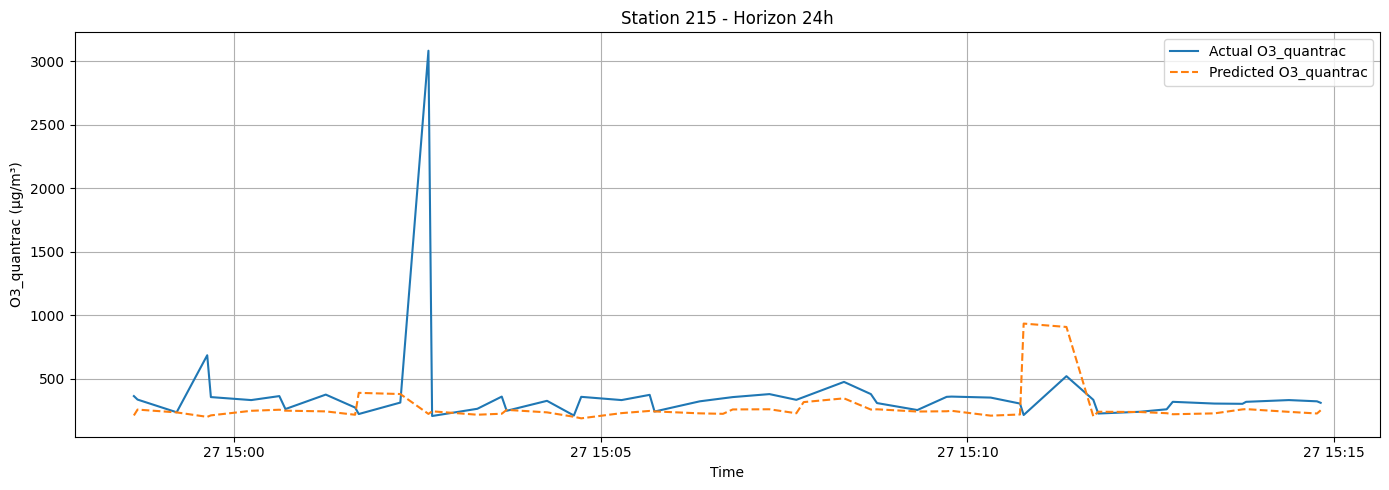

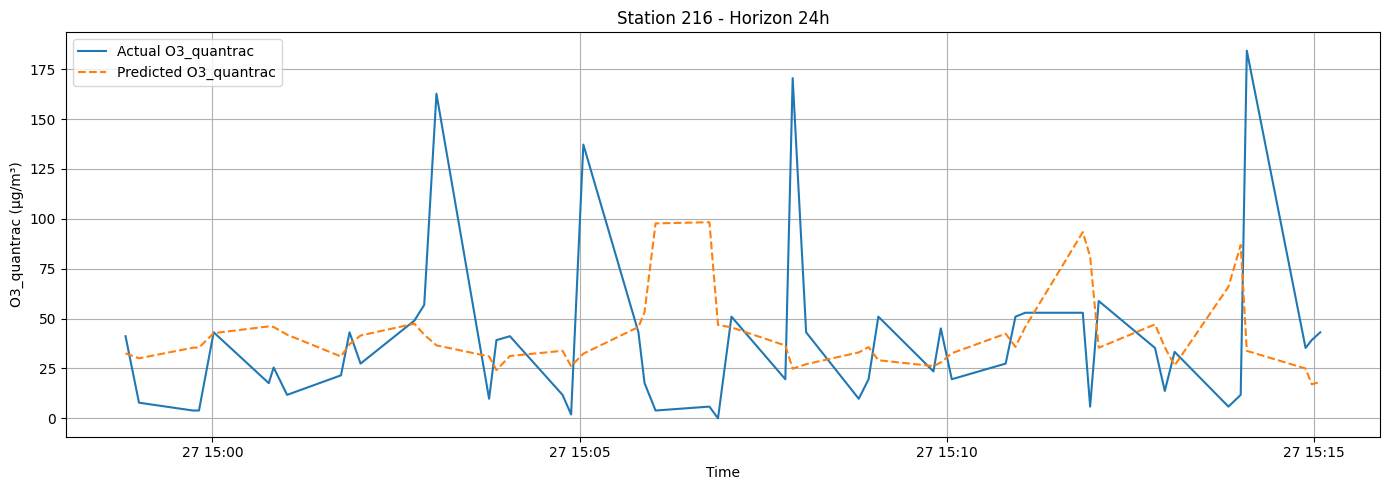

station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211         24  239.76  196.45  207.83 -150.72  0.01       2407   
1      213         24   64.04   53.95  203.01 -167.53 -0.01       2324   
2      215         24  278.16  128.20   30.27   16.56 -0.02       3581   
3      216         24   40.50   28.34  200.78 -172.41  0.00       2985   

   avg_mnbe  
0     26.45  
1     -2.75  
2     26.44  
3     -9.47

Horizon:  48
y_pred: =  [141.93101881 140.82505819 109.83389142 ...  72.10027231  57.51514927
  60.78379451]
y_pred_new: =  0        185.1355094049
1        184.5825290949
2         81.8669457084
3        161.0960072132
4        211.1375327760
              ...      
11196     54.9364554676
11197     98.5790962738
11198     94.3601361534
11199     51.2975746329
11200     50.4818972535
Name: O3_quantrac_roll2_mean, Length: 11201, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 196.94, 'mae': 103.51, 'mape': 356.32, 'mnbe': -295.52, 'r': 0.51, 'n_samples': 11201}


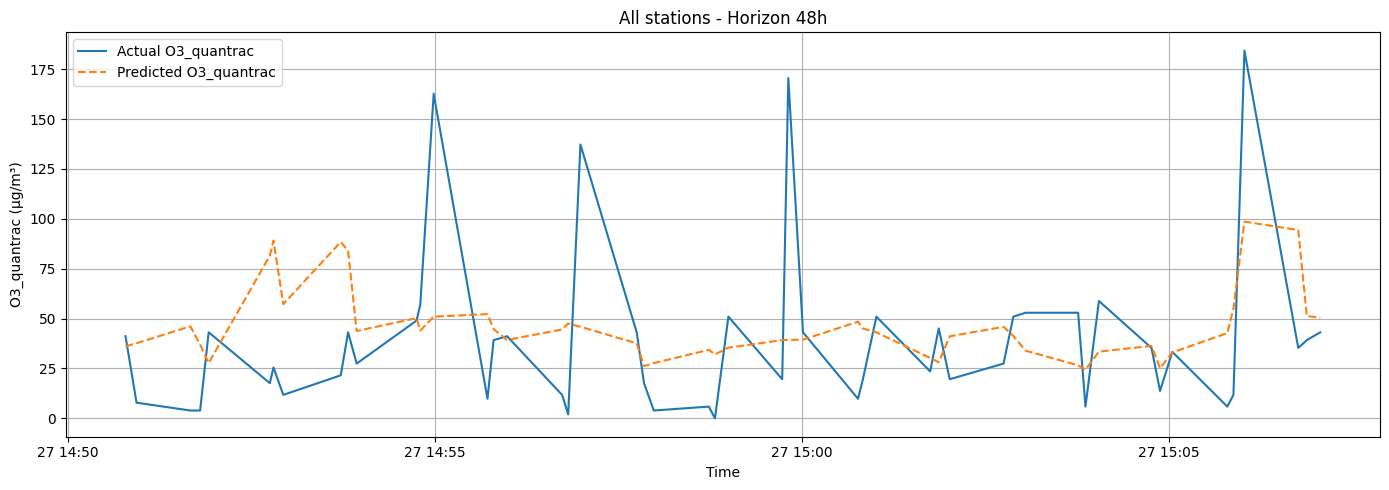


================================================== METRICS FOR EACH STATION ==================================================



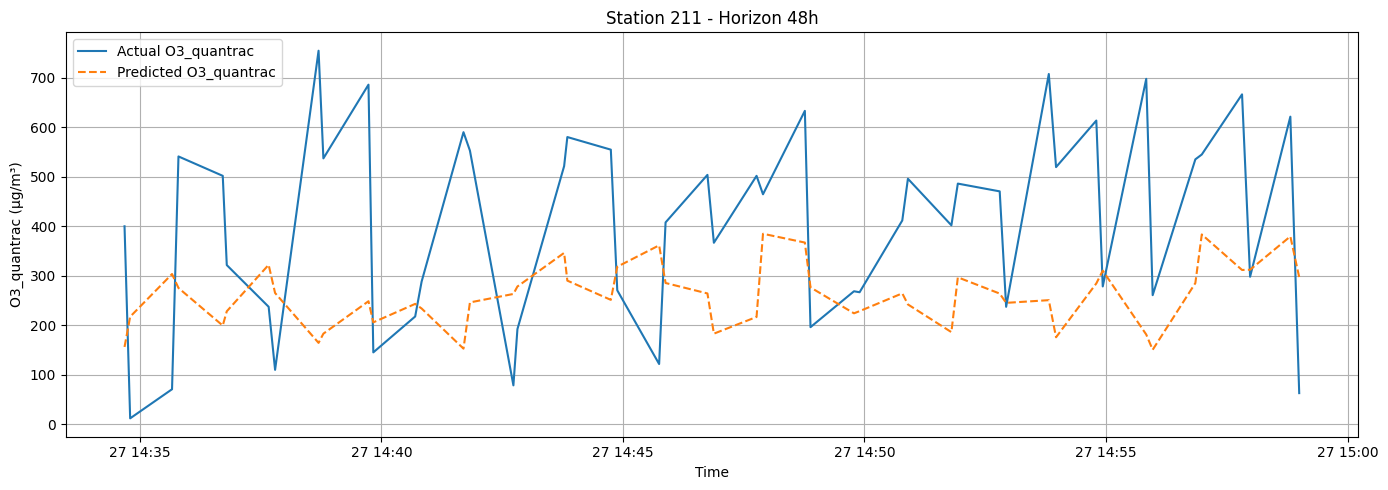

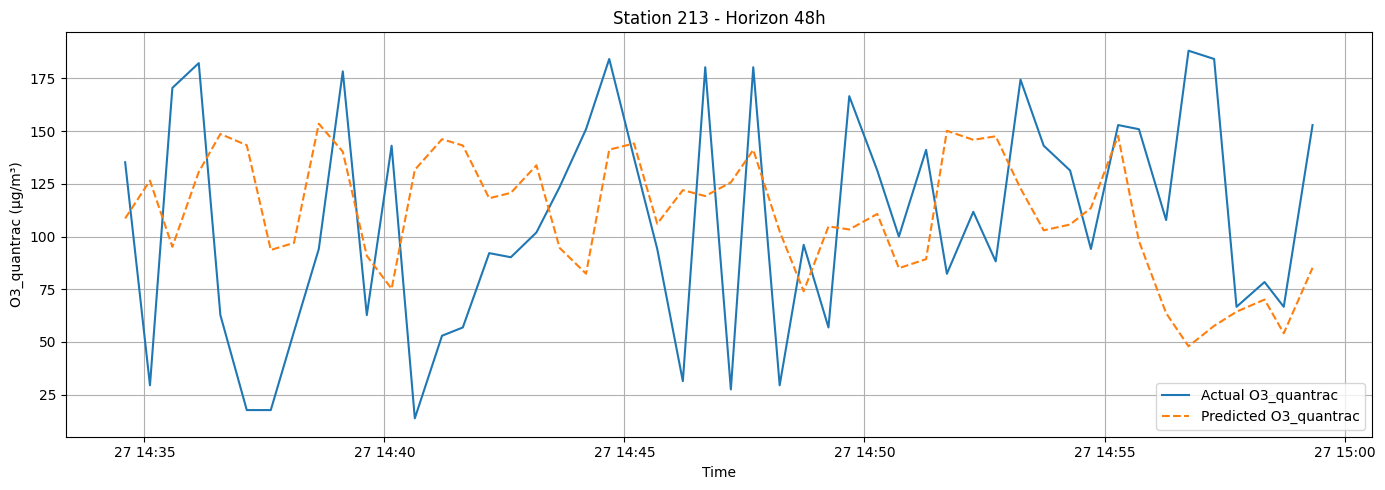

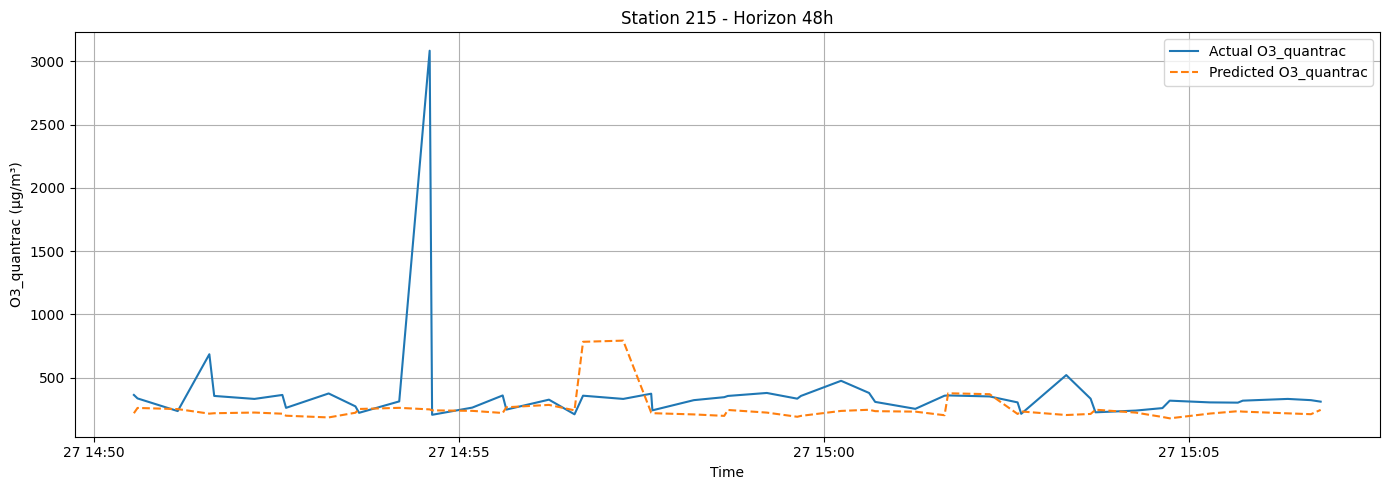

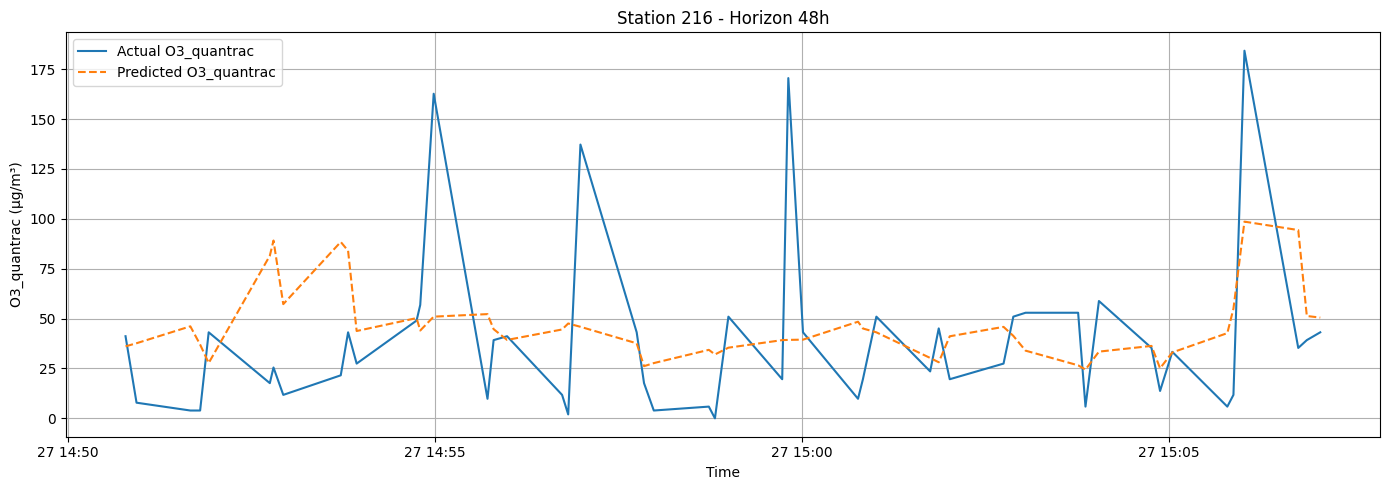

station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211         48  245.44  200.59  195.18 -133.97 -0.01       2383   
1      213         48   63.61   53.10  209.12 -177.03  0.01       2300   
2      215         48  278.91  133.31   31.90   20.13 -0.00       3557   
3      216         48   40.54   28.73  203.13 -175.72 -0.00       2961   

   avg_mnbe  
0     30.31  
1     -6.90  
2     28.99  
3    -13.50

Horizon:  72
y_pred: =  [123.70716104 121.73640287  89.3836113  ...  59.92703095  55.28424909
  39.0545877 ]
y_pred_new: =  0        176.0235805178
1        175.0382014327
2         71.6418056518
3        150.1750130392
4        211.1535632872
              ...      
11100     27.0139887208
11101     30.3640578543
11102     37.8035154729
11103     37.4421245441
11104     31.2872938512
Name: O3_quantrac_roll2_mean, Length: 11105, dtype: float64

================================================== OVERALL METRICS ==================================================

{'rmse': 190.8, 'mae': 102.19, 'mape': 350.59, 'mnbe': -288.95, 'r': 0.53, 'n_samples': 11105}


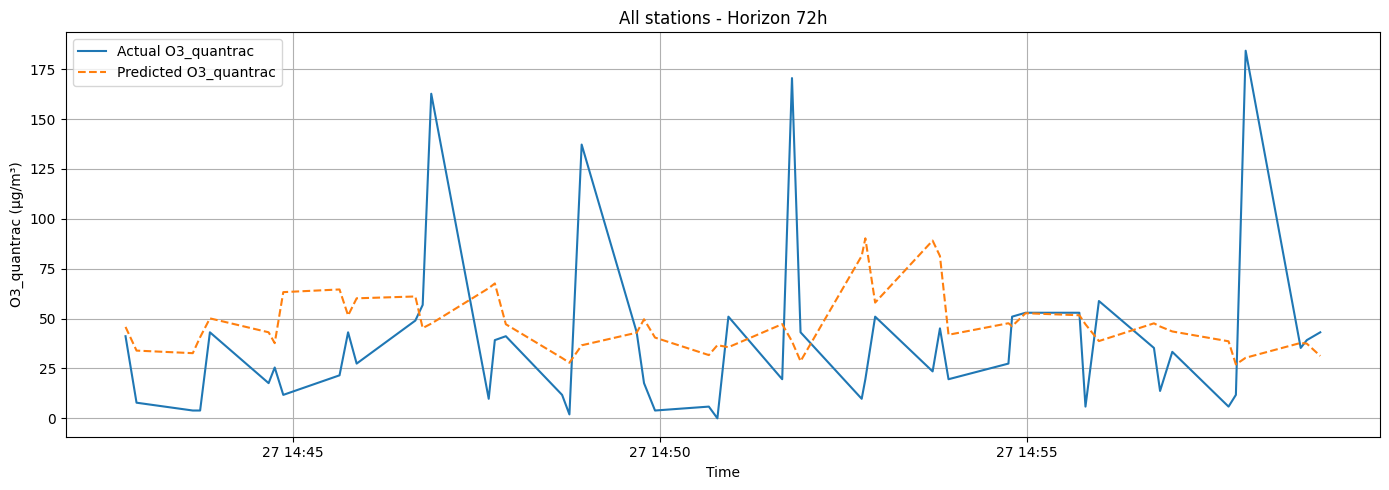


================================================== METRICS FOR EACH STATION ==================================================



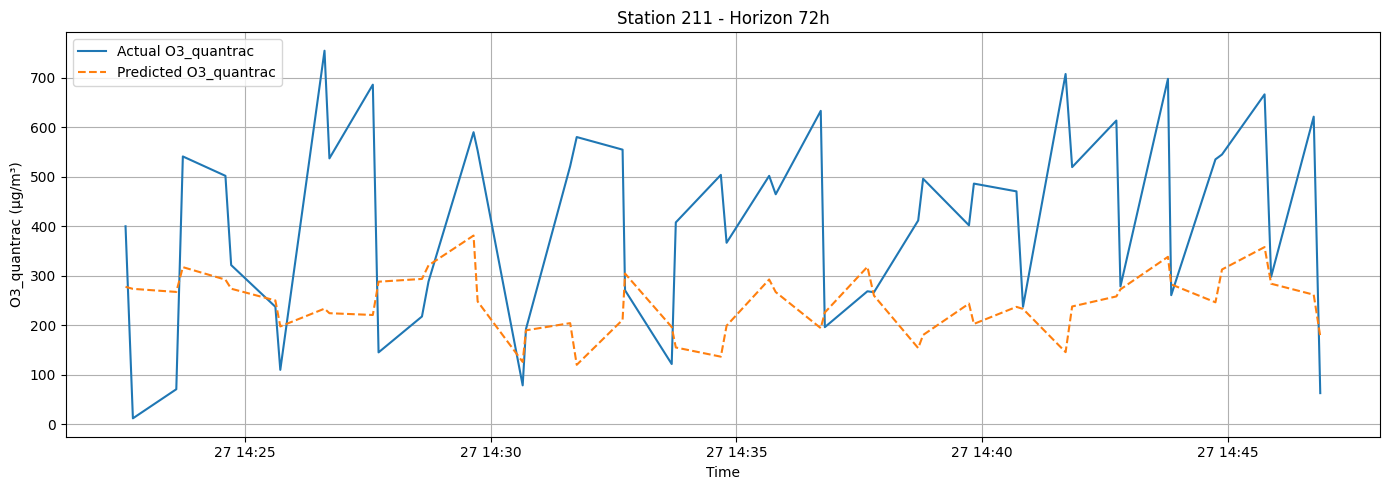

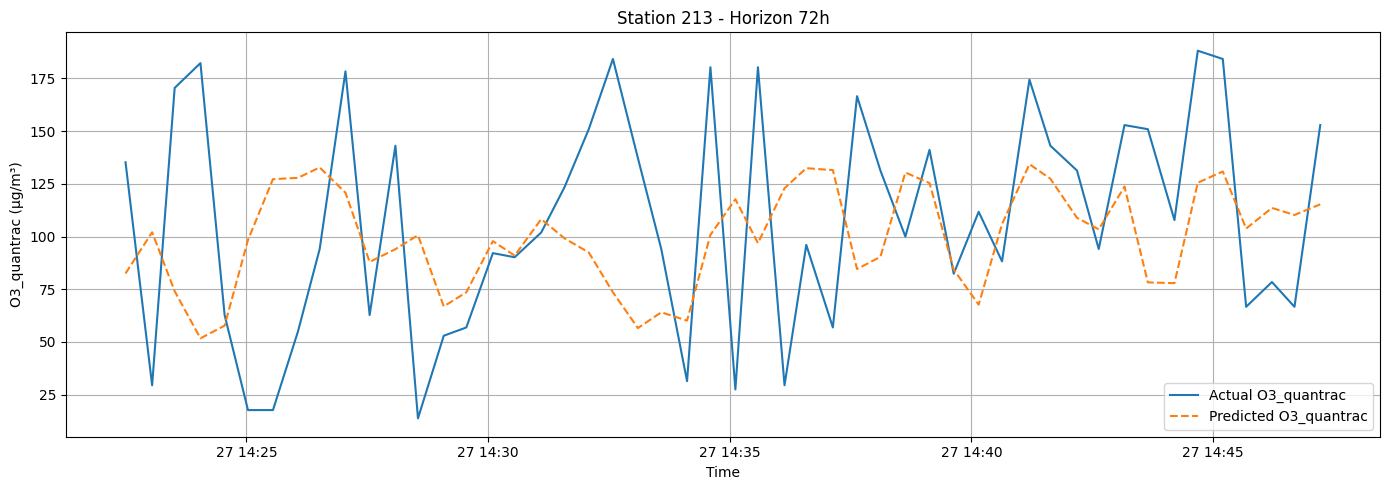

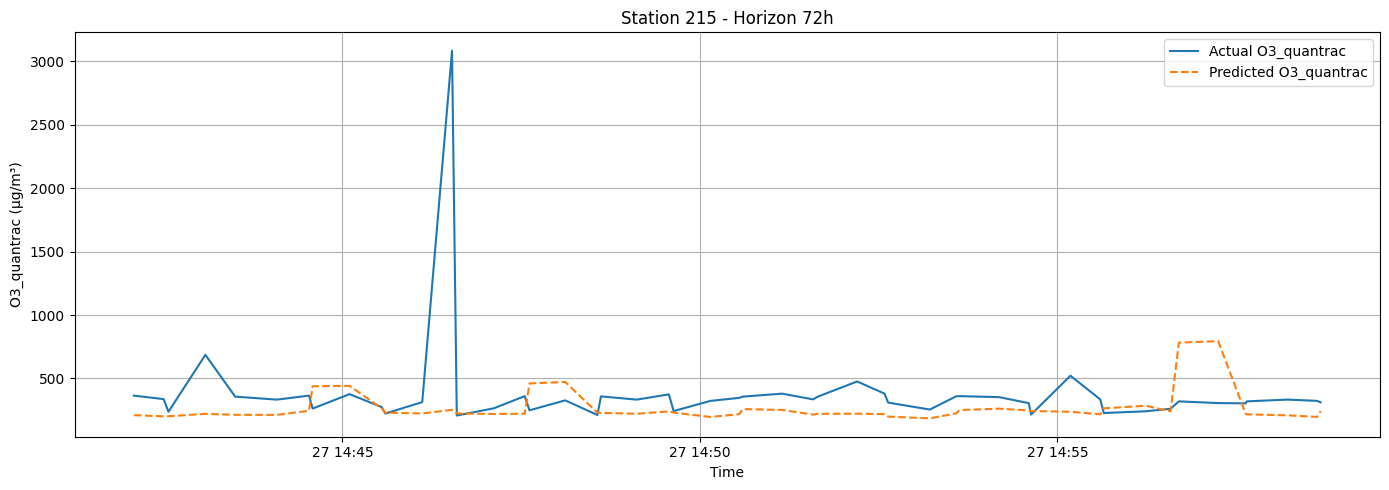

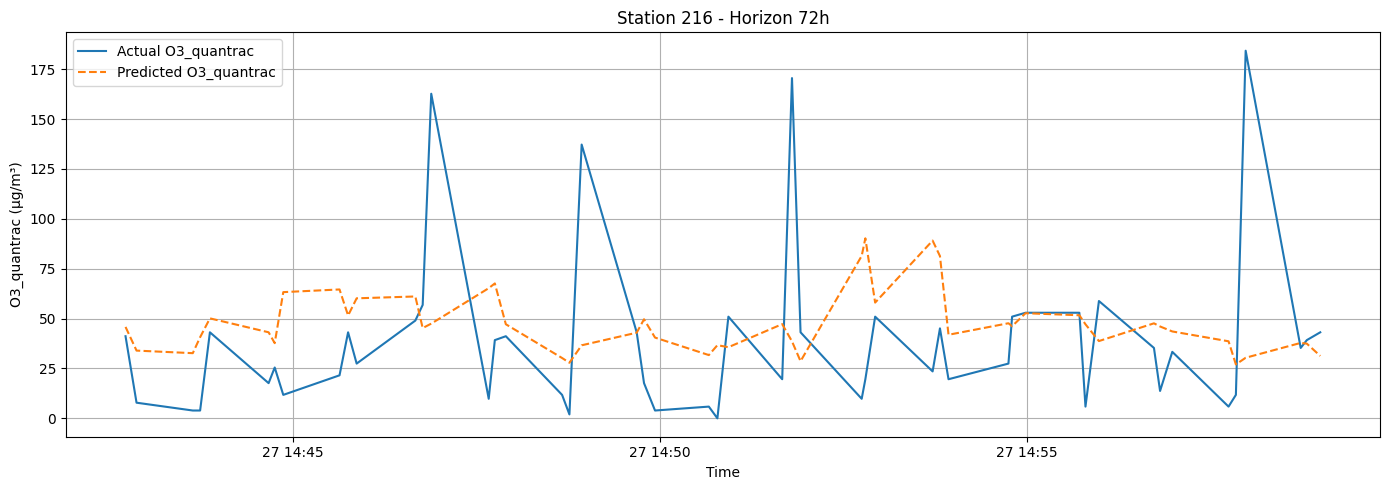

station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211         72  245.17  198.57  189.40 -127.81  0.01       2359   
1      213         72   62.00   52.19  195.23 -157.90  0.04       2276   
2      215         72  265.50  131.48   32.07   20.75  0.02       3533   
3      216         72   40.00   28.31  201.52 -176.00 -0.02       2937   

   avg_mnbe  
0     31.72  
1      1.21  
2     28.79  
3    -14.61

In [36]:
# Add rolling features for target_col
target_col = "O3_quantrac"
df_o3 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as o3_emb_file:
    o3_station_to_embedding = pickle.load(o3_emb_file)
print(o3_station_to_embedding)
df_o3, _ = attach_station_embedding(df_o3, o3_station_to_embedding, station_col="station_id")

# Dropna
df_o3 = df_o3.dropna()

for horizon_h in HORIZONS:
    print("Horizon: ", horizon_h)
    # Build supervised
    X, y = build_supervised_for_horizon(df_o3, horizon_h, target_col)
    meta_cols = ["station_id", "date"]
    meta = X.loc[:, meta_cols]
    X = X.drop(columns=meta_cols)
    y = y.drop(columns=meta_cols)
    model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    y_pred = model.predict(X, num_iteration=getattr(test_model, "best_iteration", None))

    '''
    # Shift
    shift = 0
    if shift != 0:
        y_pred = y_pred[shift:]
        y = y.iloc[:-shift, :]
        X = X.iloc[:-shift, :]
        meta = meta.iloc[:-shift, :]
    '''

    # Plus rolling mean
    print("y_pred: = ", y_pred)
    a, b, rollmean = 0.5, 0.5, 2
    y_pred_new = a * y_pred + b * X[f"{target_col}_roll{rollmean}_mean"]
    print("y_pred_new: = ", y_pred_new)

    # Metrics overall
    print(f"\n{'=' * 50} OVERALL METRICS {'=' * 50}\n")
    metrics_overall = compute_metrics(y, y_pred_new)
    print(metrics_overall)
    plot_prediction(y, y_pred_new, meta, target_col, title=f"All stations - Horizon {horizon_h}h", n_points=50)

    # Metrics for each station
    print(f"\n{'=' * 50} METRICS FOR EACH STATION {'=' * 50}\n")
    df_true_test = meta.copy()
    df_true_test["y_true"] = y.values
    df_true_test["y_pred"] = y_pred_new
    rows = []
    for sid, grp in df_true_test.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        # Calculate avg mnbe
        avg_mnbe = mnbe_avg(grp["y_true"], grp["y_pred"], grp["date"])
        m["avg_mnbe"] = round(avg_mnbe, 2)
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
        plot_prediction(grp["y_true"], grp["y_pred"], grp[["date"]], target_col, title=f"Station {sid} - Horizon {horizon_h}h", n_points=50)
    metrics_by_station = pd.DataFrame(rows)
    display(metrics_by_station)

## CO_quantrac

{211: [-9.1424675, -9.570723, -10.159096, 8.830111], 212: [-1.9979348, -4.0776124, -2.5172603, 1.1684203], 213: [-10.647095, -11.673682, -11.487389, 11.10486], 214: [-12.096144, -10.875263, -13.295887, 10.625471], 215: [-11.388142, -11.457361, -10.267969, 10.315793], 216: [-12.22883, -11.686434, -12.453338, 11.830644]}
Horizon:  1
y_pred: =  [377.59797884 491.81388713 423.4103298  ... 432.4105844  382.58630255
 392.98340092]
y_pred_new: =  0        269.3616894179
1        347.3987435627
2        350.1812649023
3        198.9074004717
4        156.3247114019
              ...      
11384    233.9197312262
11385    160.1077075584
11386    351.5276921975
11387    296.2253512743
11388    209.1065004594
Name: CO_quantrac_roll2_mean, Length: 11389, dtype: float64
{'rmse': 166.67, 'mae': 135.25, 'mape': 277.09, 'mnbe': -262.84, 'r': 0.1, 'n_samples': 11389}


station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211          1  172.24  140.93  390.25 -374.81  0.04       2430   
1      213          1  191.82  155.81  303.97 -291.43  0.04       2347   
2      215          1  136.73  111.90   55.24  -46.38 -0.01       3604   
3      216          1  173.52  142.60  377.46 -360.40  0.03       3008   

   avg_mnbe  
0    -35.83  
1    -38.48  
2    -27.54  
3    -35.38

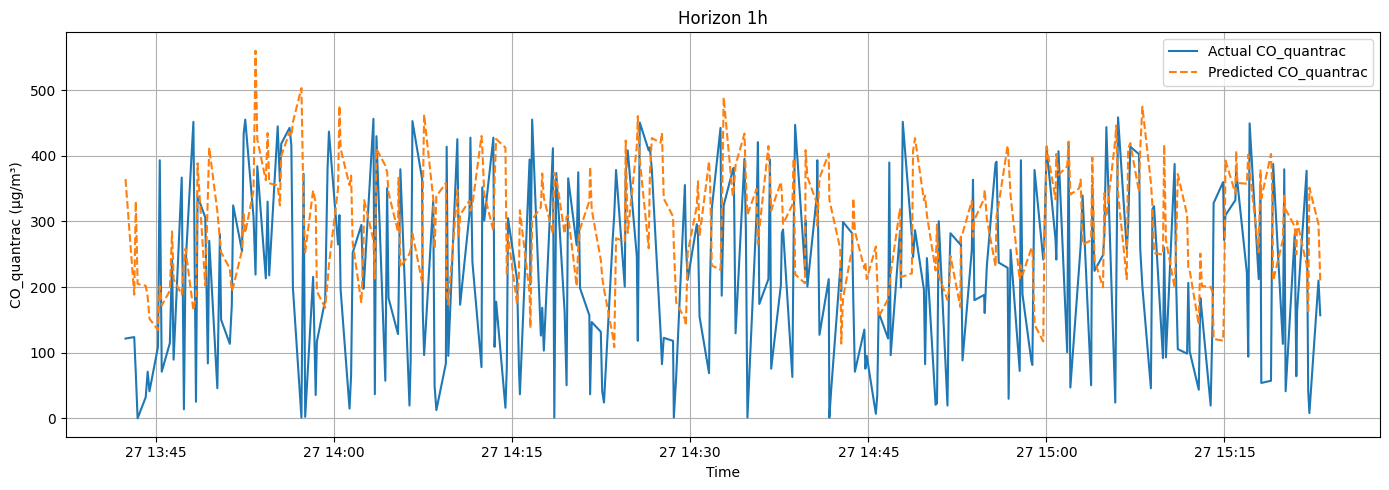

Horizon:  24
y_pred: =  [437.83485911 428.86965306 382.91243883 ... 395.56633519 316.53600043
 371.01087181]
y_pred_new: =  0        299.4801295548
1        315.9266265282
2        329.9323194161
3        294.1047774497
4        250.3064443682
              ...      
11292    280.8023072899
11293    226.2138346829
11294    241.3615675930
11295    278.9687002126
11296    357.5254359068
Name: CO_quantrac_roll2_mean, Length: 11297, dtype: float64
{'rmse': 174.41, 'mae': 142.6, 'mape': 300.61, 'mnbe': -292.35, 'r': 0.11, 'n_samples': 11297}


station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211         24  183.24  149.84  448.95 -440.51  0.02       2407   
1      213         24  189.60  155.35  300.82 -291.35  0.05       2324   
2      215         24  152.22  124.70   63.18  -59.19 -0.01       3581   
3      216         24  179.63  148.29  416.30 -406.10  0.01       2985   

   avg_mnbe  
0    -50.45  
1    -40.82  
2    -36.17  
3    -46.71

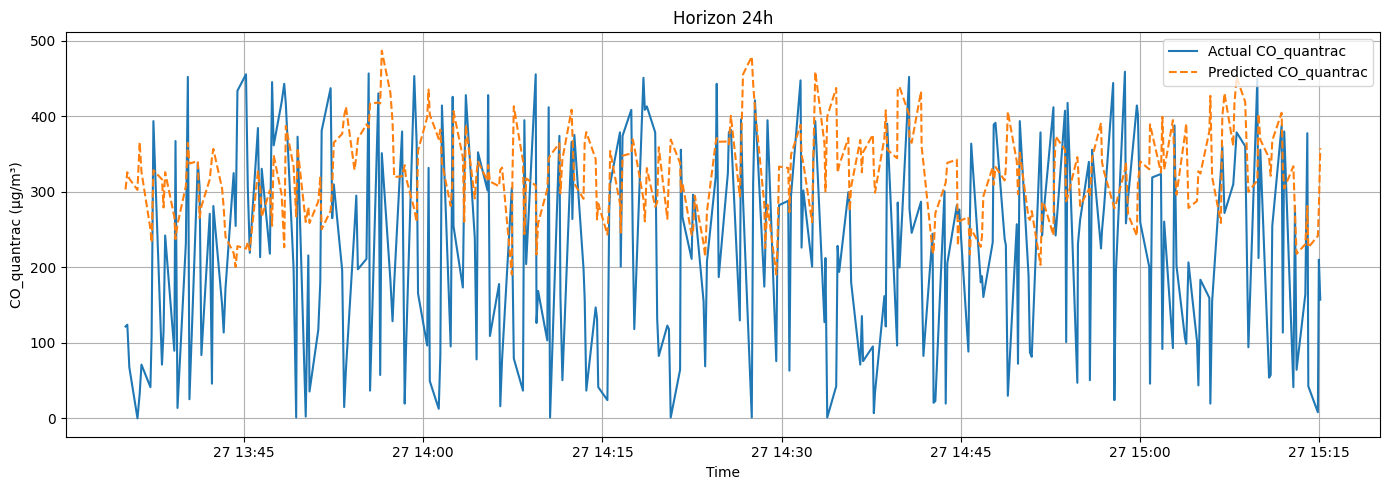

Horizon:  48
y_pred: =  [464.92901378 515.22487547 537.32350822 ... 549.2635766  487.60247777
 483.14084158]
y_pred_new: =  0        313.0272068904
1        359.1042377362
2        407.1378541112
3        364.1946392641
4        246.9103099417
              ...      
11196    455.7658412674
11197    343.7257066283
11198    329.6781882998
11199    407.5069388855
11200    420.7579207888
Name: CO_quantrac_roll2_mean, Length: 11201, dtype: float64
{'rmse': 191.32, 'mae': 156.09, 'mape': 325.93, 'mnbe': -321.18, 'r': 0.06, 'n_samples': 11201}


station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211         48  206.10  169.83  499.33 -494.80 -0.00       2383   
1      213         48  201.95  164.95  323.43 -316.86  0.03       2300   
2      215         48  157.24  129.23   65.57  -62.56  0.02       3557   
3      216         48  207.12  170.42  458.80 -454.20  0.02       2961   

   avg_mnbe  
0    -65.71  
1    -49.60  
2    -40.75  
3    -66.36

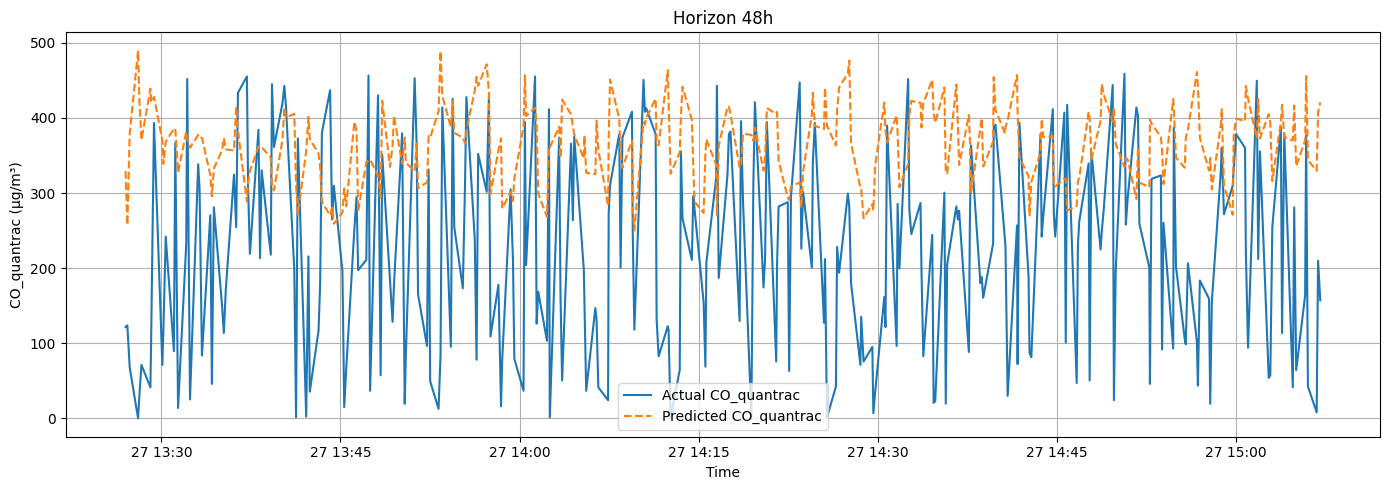

Horizon:  72
y_pred: =  [554.75410724 577.62202639 574.50442161 ... 566.96466032 585.40934295
 530.85744813]
y_pred_new: =  0        357.9397536196
1        390.3028131930
2        425.7283108038
3        364.7355348636
4        305.1821177551
              ...      
11100    366.0677555861
11101    346.4333323782
11102    399.8825301598
11103    438.3482714741
11104    334.5234240672
Name: CO_quantrac_roll2_mean, Length: 11105, dtype: float64
{'rmse': 221.41, 'mae': 184.78, 'mape': 362.12, 'mnbe': -359.77, 'r': 0.05, 'n_samples': 11105}


station  horizon_h    rmse     mae    mape    mnbe     r  n_samples  \
0      211         72  231.84  194.24  569.81 -567.54 -0.00       2359   
1      213         72  223.46  183.92  353.05 -348.88  0.03       2276   
2      215         72  191.52  162.87   80.74  -79.93  0.01       3533   
3      216         72  243.65  204.20  536.03 -533.72 -0.02       2937   

   avg_mnbe  
0    -78.77  
1    -60.03  
2    -53.84  
3    -80.04

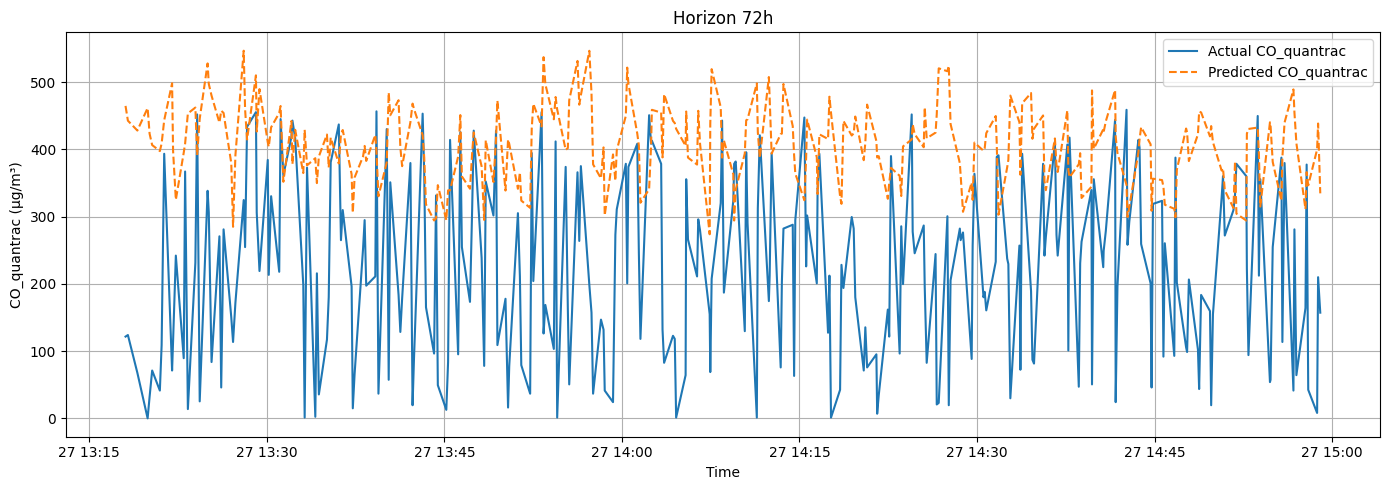

In [15]:
# Add rolling features for target_col
target_col = "CO_quantrac"
df_co = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as co_emb_file:
    co_station_to_embedding = pickle.load(co_emb_file)
print(co_station_to_embedding)
df_co, _ = attach_station_embedding(df_co, co_station_to_embedding, station_col="station_id")

# Dropna
df_co = df_co.dropna()

for horizon_h in HORIZONS:
    print("Horizon: ", horizon_h)
    # Build supervised
    X, y = build_supervised_for_horizon(df_co, horizon_h, target_col)
    meta_cols = ["station_id", "date"]
    meta = X.loc[:, meta_cols]
    X = X.drop(columns=meta_cols)
    y = y.drop(columns=meta_cols)
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    y_pred = test_model.predict(X, num_iteration=getattr(test_model, "best_iteration", None))

    # Plus rolling mean
    print("y_pred: = ", y_pred)
    a, b, rollmean = 0.5, 0.5, 2
    y_pred_new = a * y_pred + b * X[f"{target_col}_roll{rollmean}_mean"]
    print("y_pred_new: = ", y_pred_new)

    # Metrics overall
    metrics_overall = compute_metrics(y, y_pred_new)
    print(metrics_overall)

    # Metrics for each station
    df_true_test = meta.copy()
    df_true_test["y_true"] = y.values
    df_true_test["y_pred"] = y_pred_new
    rows = []
    for sid, grp in df_true_test.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        # Calculate avg mnbe
        avg_mnbe = mnbe_avg(grp["y_true"], grp["y_pred"], grp["date"])
        m["avg_mnbe"] = round(avg_mnbe, 2)
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
    metrics_by_station = pd.DataFrame(rows)
    display(metrics_by_station)

    plot_prediction(y, y_pred_new, meta, target_col, title=f"Horizon {horizon_h}h")